## EAPE Budget Profile

### Import package

In [12]:
import json
import numpy as np
import netCDF4 as nc

from typing import Tuple
from scipy.ndimage import convolve1d
from itertools import product
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm

exec(open("/home/b11209013/Package/Plot_Style.py").read())


%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


### Functions

In [13]:
# Compute stability
def compute_stability(
    lev: np.ndarray,
    theta: np.ndarray,
    density: np.ndarray,
) -> np.ndarray:

    theta_mean = theta.mean(axis=(0, -1), keepdims=True)

    density_mean = density.mean(axis=(0, -1), keepdims=True)

    theta_grad = np.gradient(theta_mean, lev * 100.0, axis=1)

    return (-theta_grad / (density_mean * theta_mean)).squeeze()[:, None]


# compute EAPE generation
def compute_generation(
    lev: np.ndarray, stab: np.ndarray, alpha: np.ndarray, heating: np.ndarray
) -> np.ndarray:
    return 287.5 * heating * alpha / (lev[:, None] * 100.0 * 1004.5 * stab)


# compute EAPE conversion
def compute_conversion(
    alpha: np.ndarray,
    omega: np.ndarray,
) -> np.ndarray:
    return alpha * omega

# compute vertical integral
def vert_int(
        lev: np.ndarray,
        data: np.ndarray,
) -> np.float64:
    print(data.shape)
    return -np.trapz(data, lev*100.0) / -np.trapz(np.ones_like(lev), lev*100.0)

### Load data

In [14]:
# Load dimensions
fpath: str = "/data92/b11209013/MPAS/merged_data"

exp_list: list[str] = ["CNTL", "NCRF"]

var_list: list[str] = ["w", "q1", "theta"]

iter_list: list[Tuple] = list(product(exp_list, var_list))

# load dimensions
with nc.Dataset(fpath + "/CNTL/theta.nc") as ds:

    dims: dict[str, np.ndarray] = {key: ds[key][:] for key in ds.dimensions.keys()}

    lat_lim: np.ndarray = np.where((dims["lat"] >= -5.0) & (dims["lat"] <= 5.0))[0]

    dims["lat"] = dims["lat"][lat_lim]

    dims["time"] = dims["time"][-360:]
    print(dims["lev"])
    converter: np.ndarray = (1000.0 / dims["lev"][None, :, None]) ** (-0.286)

print("Finished: Loading dimensions")

# Load variables
data: dict[str, dict[str, np.ndarray]] = {var: {} for var in var_list}

for exp, var in iter_list:
    with nc.Dataset(fpath + f"/{exp}/{var}.nc") as ds:
        data[var][exp] = ds[var][-360:][..., lat_lim, :].mean(axis=2)

    print(f"Finished: Loading {exp} {var}")

print("Finished: Loading data")

# Compute specific variables
data["temp"] = {
    exp: data["theta"][exp] * converter
    for exp in exp_list
}

# Compute density
data["rho"] = {
    exp: dims["lev"][None, :, None]*100.0 / 287.5 / data["temp"][exp]
    for exp in exp_list
}

# compute omega
data["omega"] = {
    exp: -9.81 * data["rho"][exp] * data["w"][exp]
    for exp in exp_list
}

# compute alpha
data["alpha"] = {
    exp: 1 / data["rho"][exp]
    for exp in exp_list
}
var_list = data.keys()
print("Finished: Compute variables")

# Load events
with open("/home/b11209013/2025_Research/AOGS/File/events.json", "r") as f:
    events = json.load(f)

# load boundary
with open("/home/b11209013/2025_Research/AOGS/File/boundary.json", "r") as f:
    bnd = json.load(f)

[1000.  985.  965.  945.  925.  900.  875.  850.  825.  800.  775.  750.
  725.  700.  675.  650.  625.  600.  575.  550.  525.  500.  475.  450.
  425.  400.  375.  350.  325.  300.  275.  250.  225.  200.  175.  150.
  125.  100.]
Finished: Loading dimensions
Finished: Loading CNTL w
Finished: Loading CNTL q1
Finished: Loading CNTL theta
Finished: Loading NCRF w
Finished: Loading NCRF q1
Finished: Loading NCRF theta
Finished: Loading data
Finished: Compute variables


### Comute anomalies

In [15]:
anom: dict[str, dict[str, np.ndarray]] = {
    var: {
        exp: data[var][exp] -
        data[var][exp].mean(axis=(0, -1), keepdims=True)
        for exp in exp_list
    } for var in var_list
}

### Select data

In [16]:
center_idx = 360//2

sel_data: dict[str, dict[str, np.ndarray]] = {
    var: {
        exp: np.array([
            np.roll(anom[var][exp][..., x], center_idx-t, axis=0)
            for x, t in zip(events[exp]["active_x"], events[exp]["active_t"])
        ]).mean(axis=0)[center_idx+bnd[exp][0]:center_idx+bnd[exp][-1]].T
        for exp in exp_list
    }
    for var in var_list
}

print("Finished: Selecting data")

Finished: Selecting data


### Compute variables

In [17]:
# Compute stability
stab: dict[str, np.ndarray] = {
    exp: compute_stability(
        dims["lev"],
        data["theta"][exp],
        data["rho"][exp]
    ) for exp in exp_list
}

print("Finished: Computing stability")

# compute generation
gen: dict[str, np.ndarray] = {
    exp: compute_generation(
        dims["lev"],
        stab[exp],
        sel_data["alpha"][exp],
        sel_data["q1"][exp]
    ) for exp in exp_list
}

print("Finished: Computing generation")

# compute conversion
conv: dict[str, np.ndarray] = {
    exp: compute_conversion(
        sel_data["alpha"][exp],
        sel_data["omega"][exp]
    )
    for exp in exp_list
}

print("Finished: Computing conversion")

# compute specific volume variance
a_var: dict[str, np.ndarray] = {
    exp: sel_data["alpha"][exp] * sel_data["alpha"][exp]
    for exp in exp_list
}

# Compute variance tendency
var_tend: dict[str, np.ndarray] = {
    exp: np.gradient(a_var[exp] / (2*stab[exp]), 6*3600.0, axis=1)
    for exp in exp_list
}

print("Finished: Computing variance tendency")

# Compute difference in generation
gen_diff: np.ndarray = gen["NCRF"] - gen["CNTL"]

# Compute difference in conversion
conv_diff: np.ndarray = conv["NCRF"] - conv["CNTL"]

# Compute difference in variance
var_diff: np.ndarray = a_var["NCRF"] - a_var["CNTL"]

# Compute difference in tendency
tend_diff: np.ndarray = var_tend["NCRF"] - var_tend["CNTL"]

Finished: Computing stability
Finished: Computing generation
Finished: Computing conversion
Finished: Computing variance tendency


### Plot profile

In [18]:
apply_custom_plot_style() # type: ignore

# setup dimensions
x = np.arange(bnd["CNTL"][0], bnd["CNTL"][-1], 1) / 4.0
z = dims["lev"]

z_lim = np.argmin(np.abs(z-150))+1

z = z[:z_lim]

xx, zz = np.meshgrid(x, z[:z_lim])

#### EAPE Generation

(36,)
0.0004309356470663166


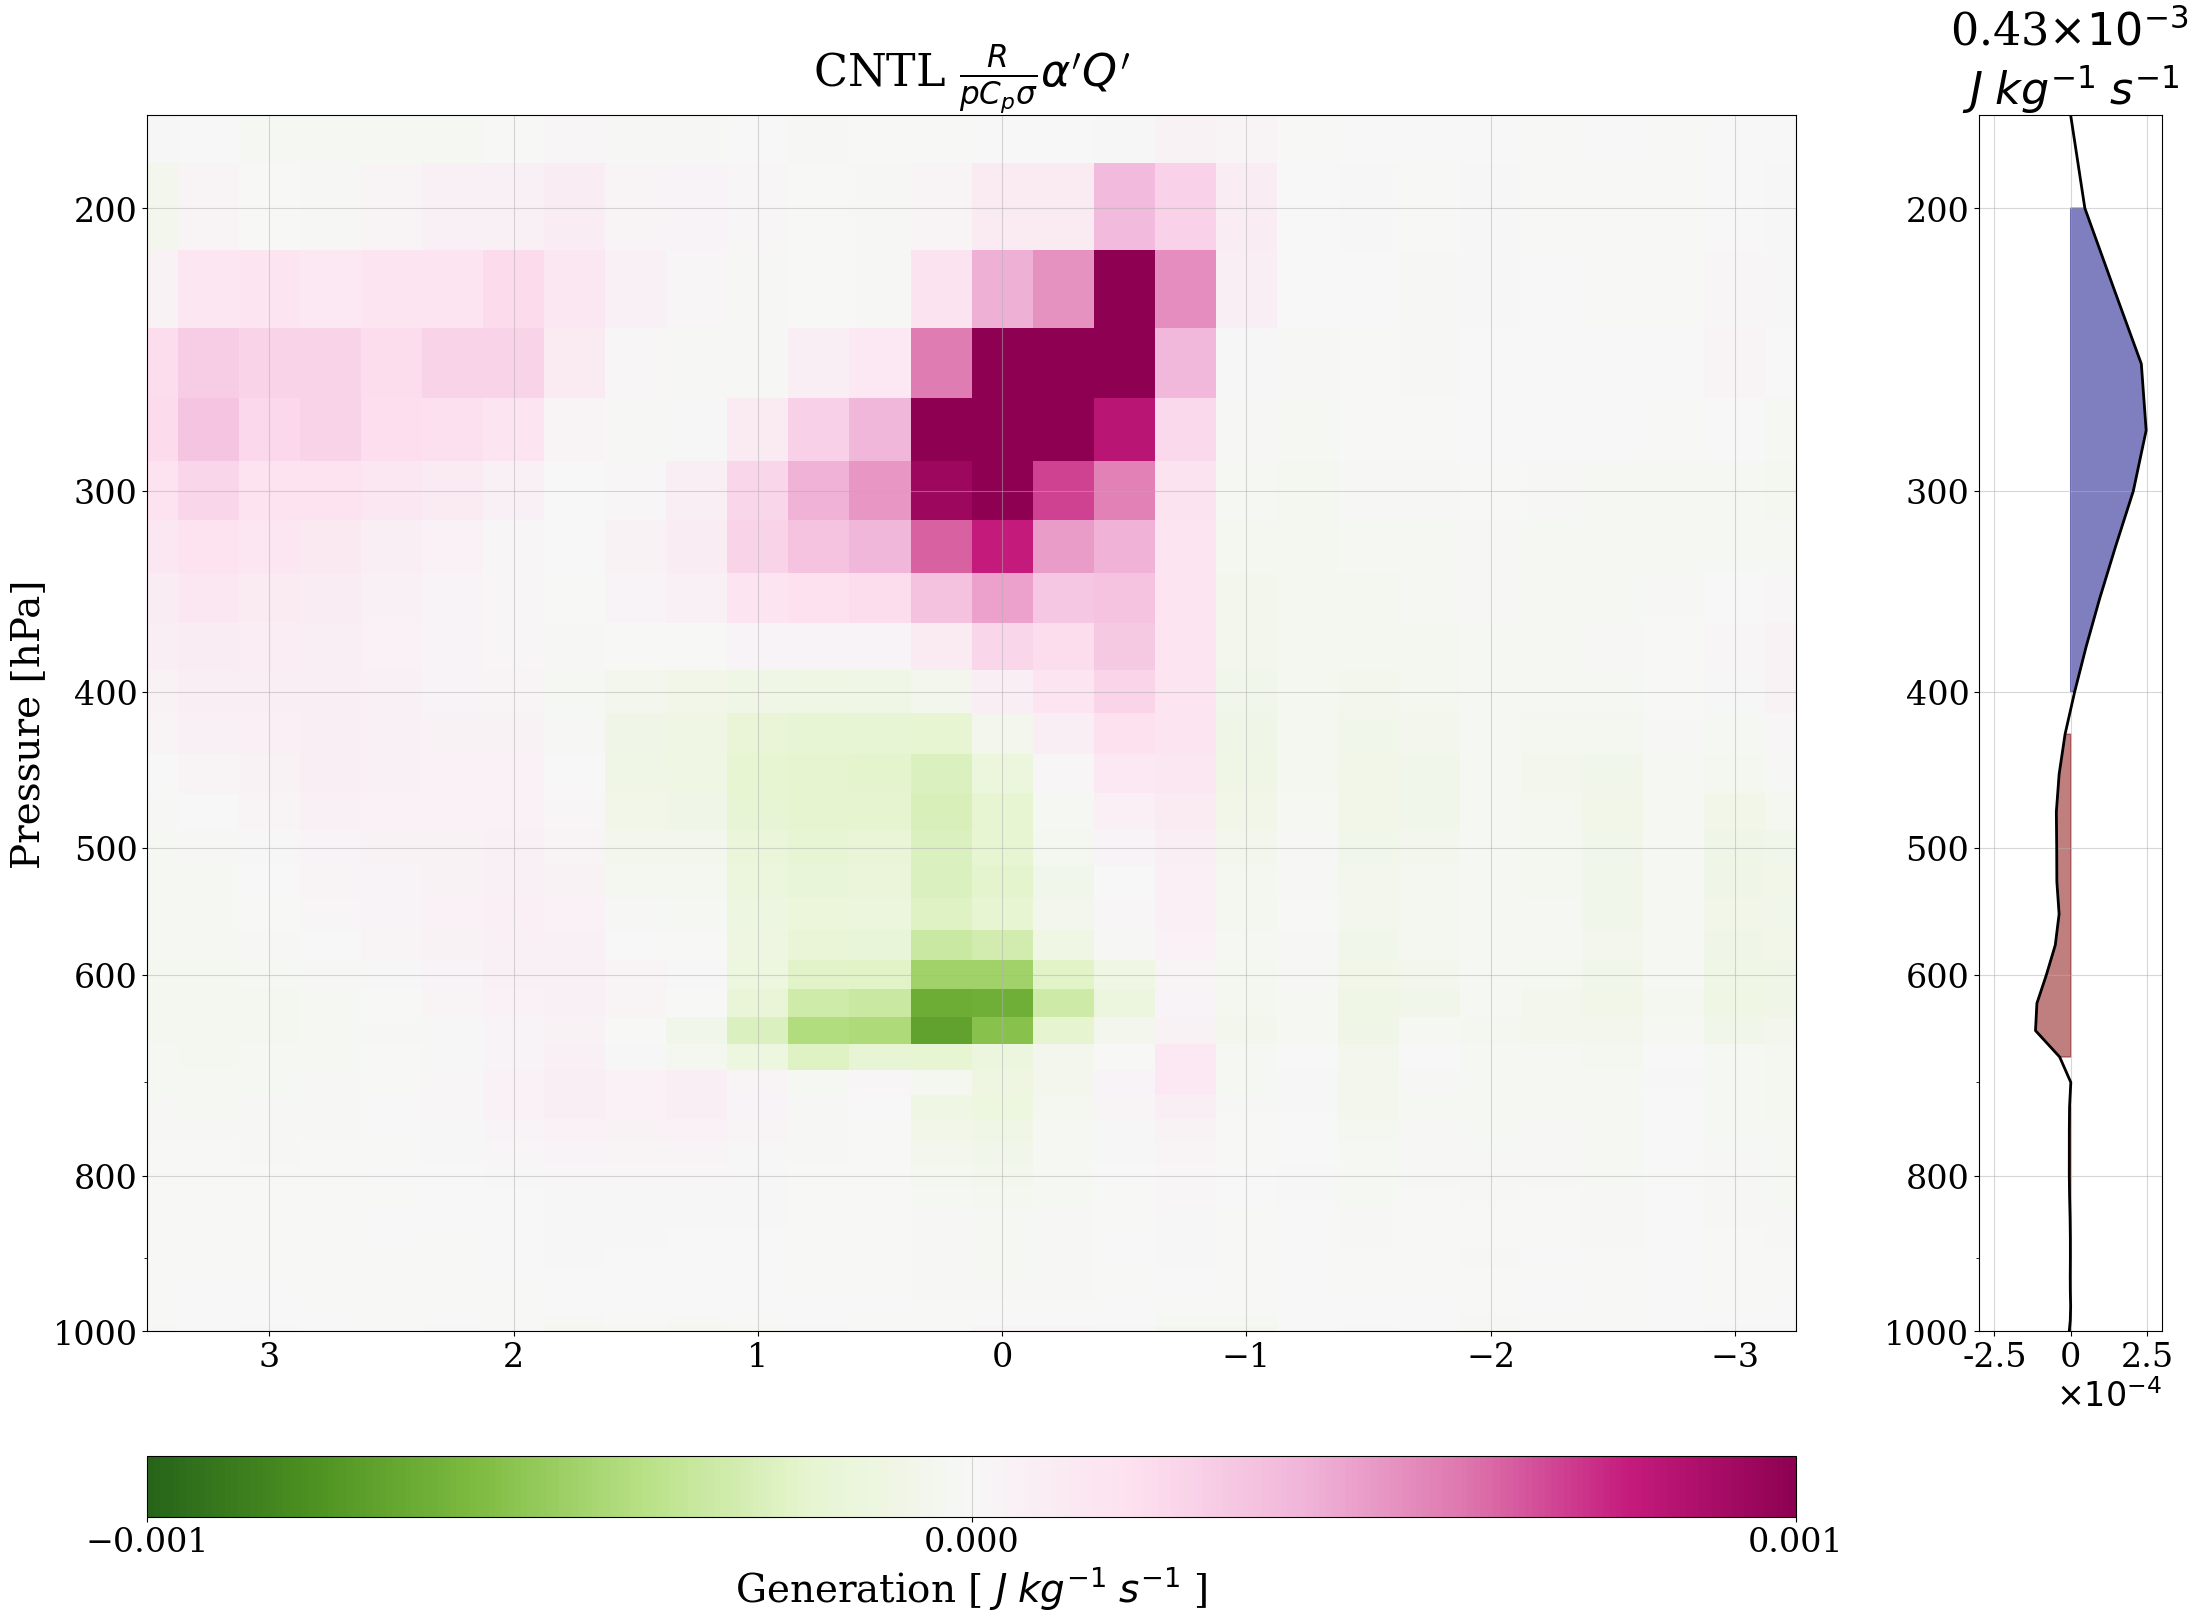

(36,)


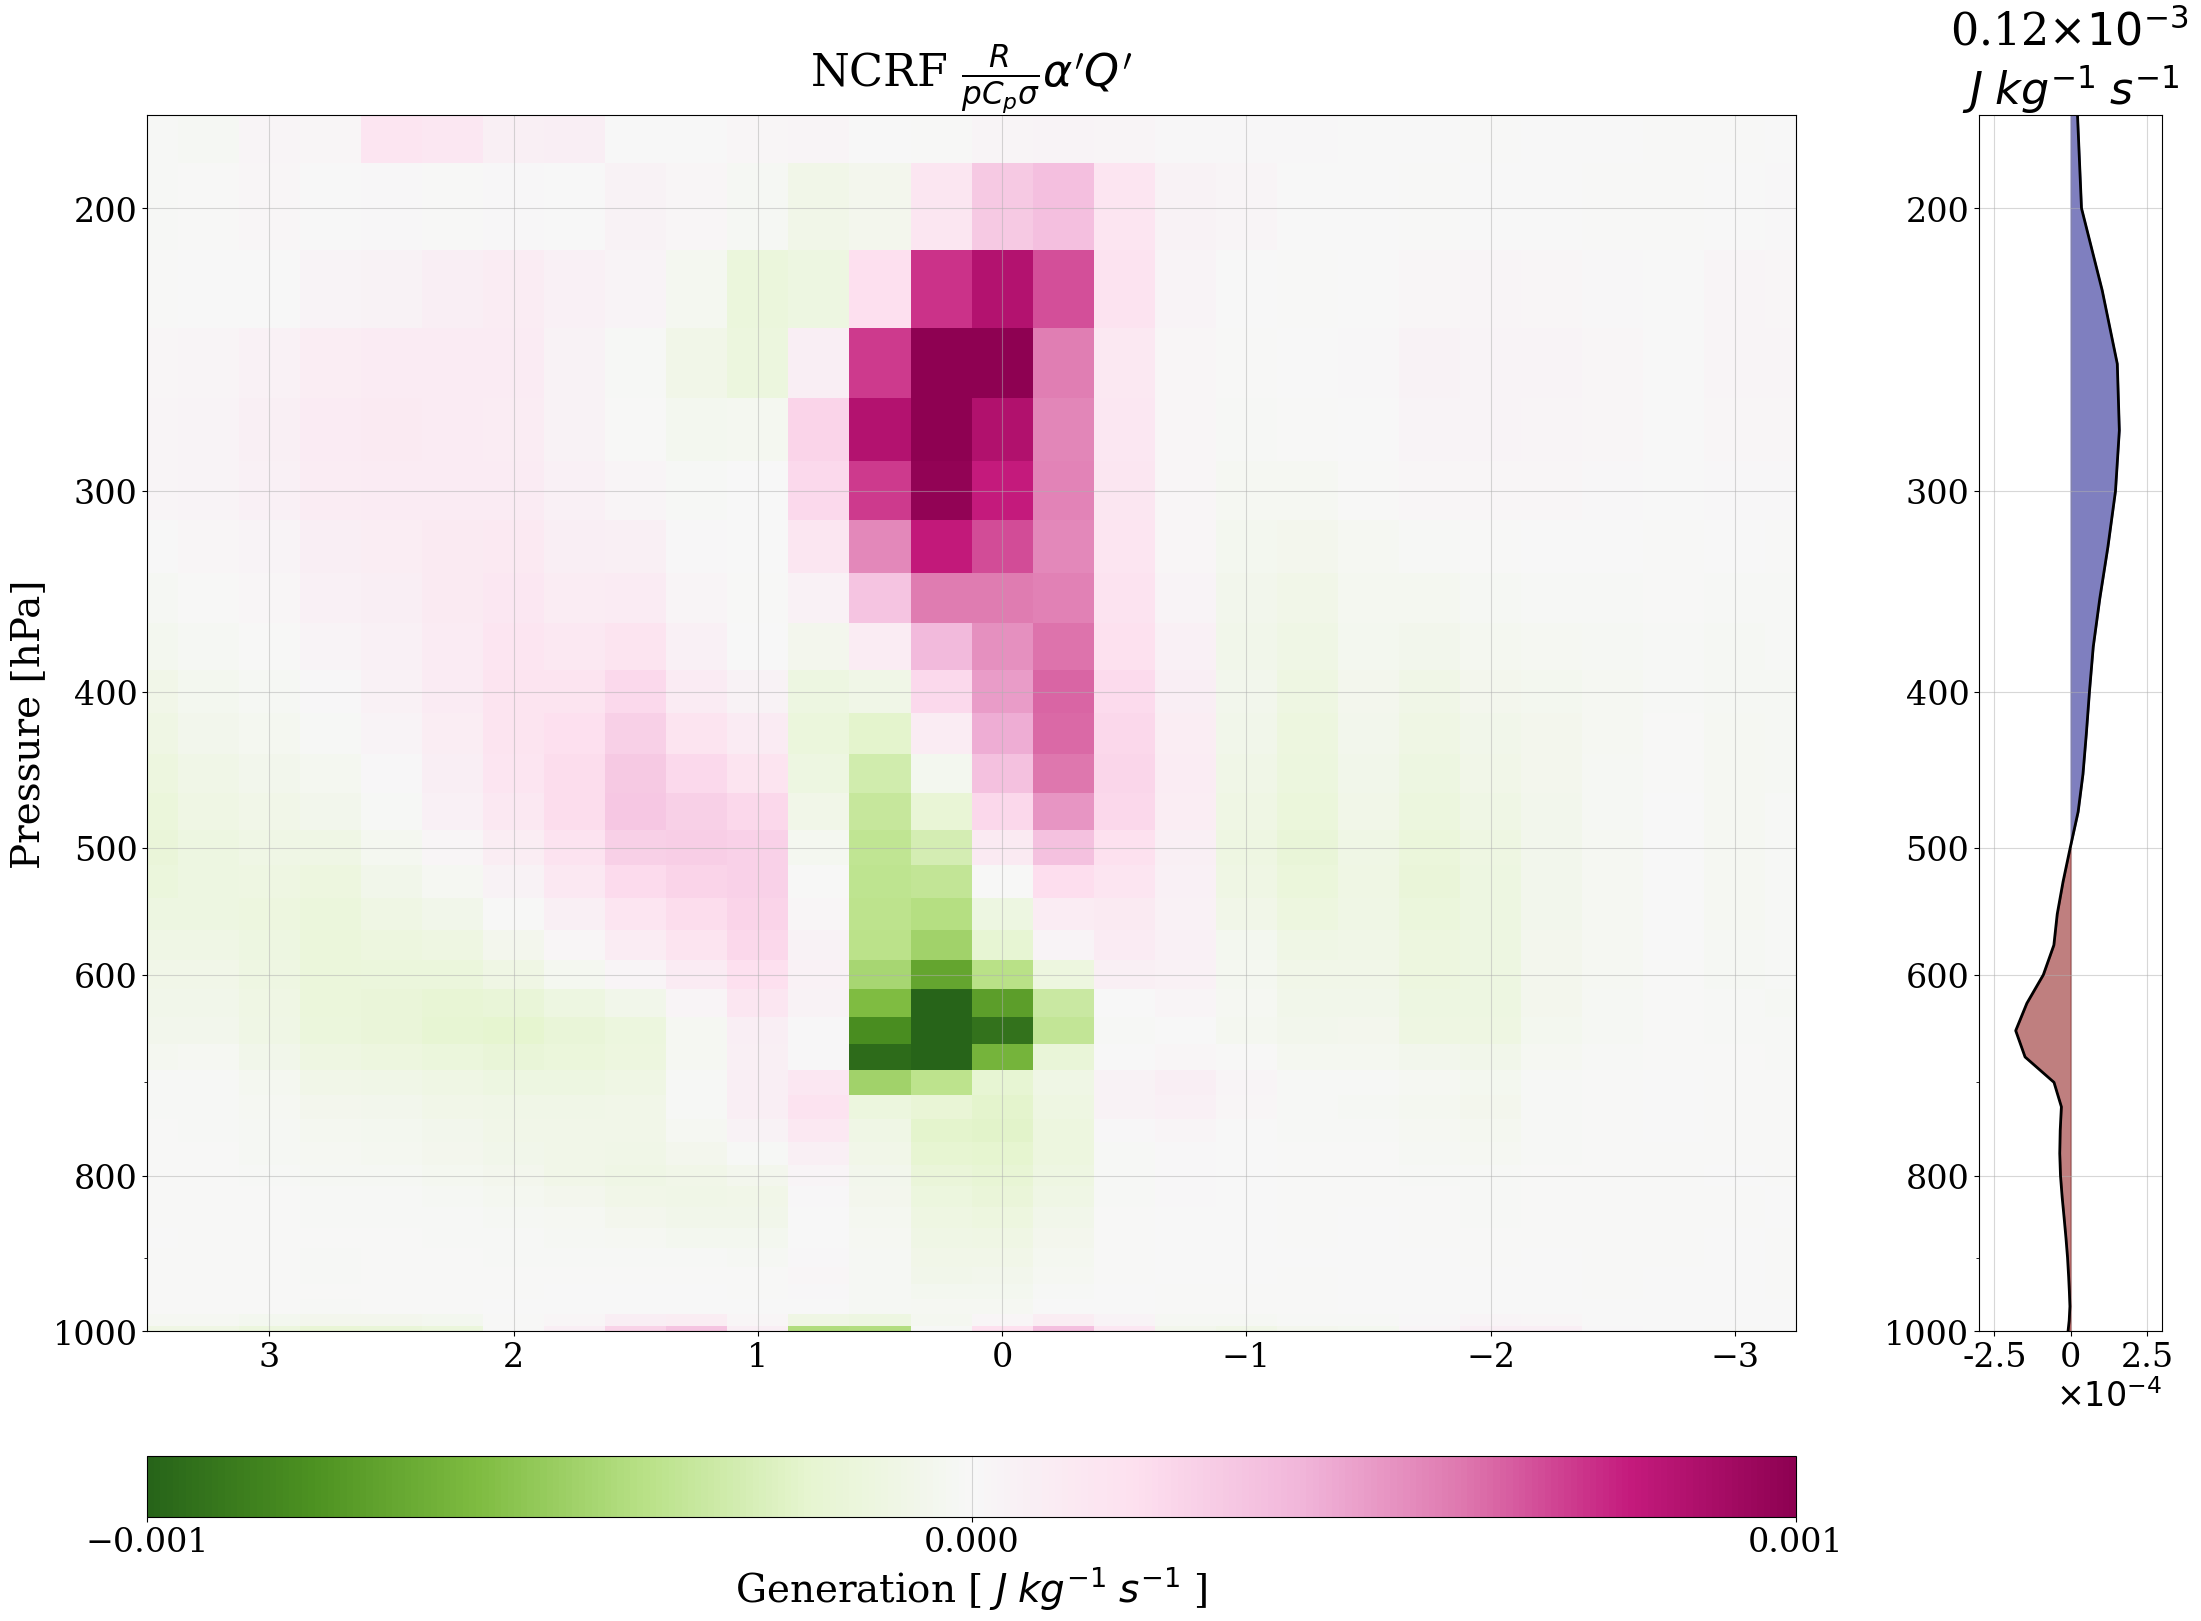

(36,)


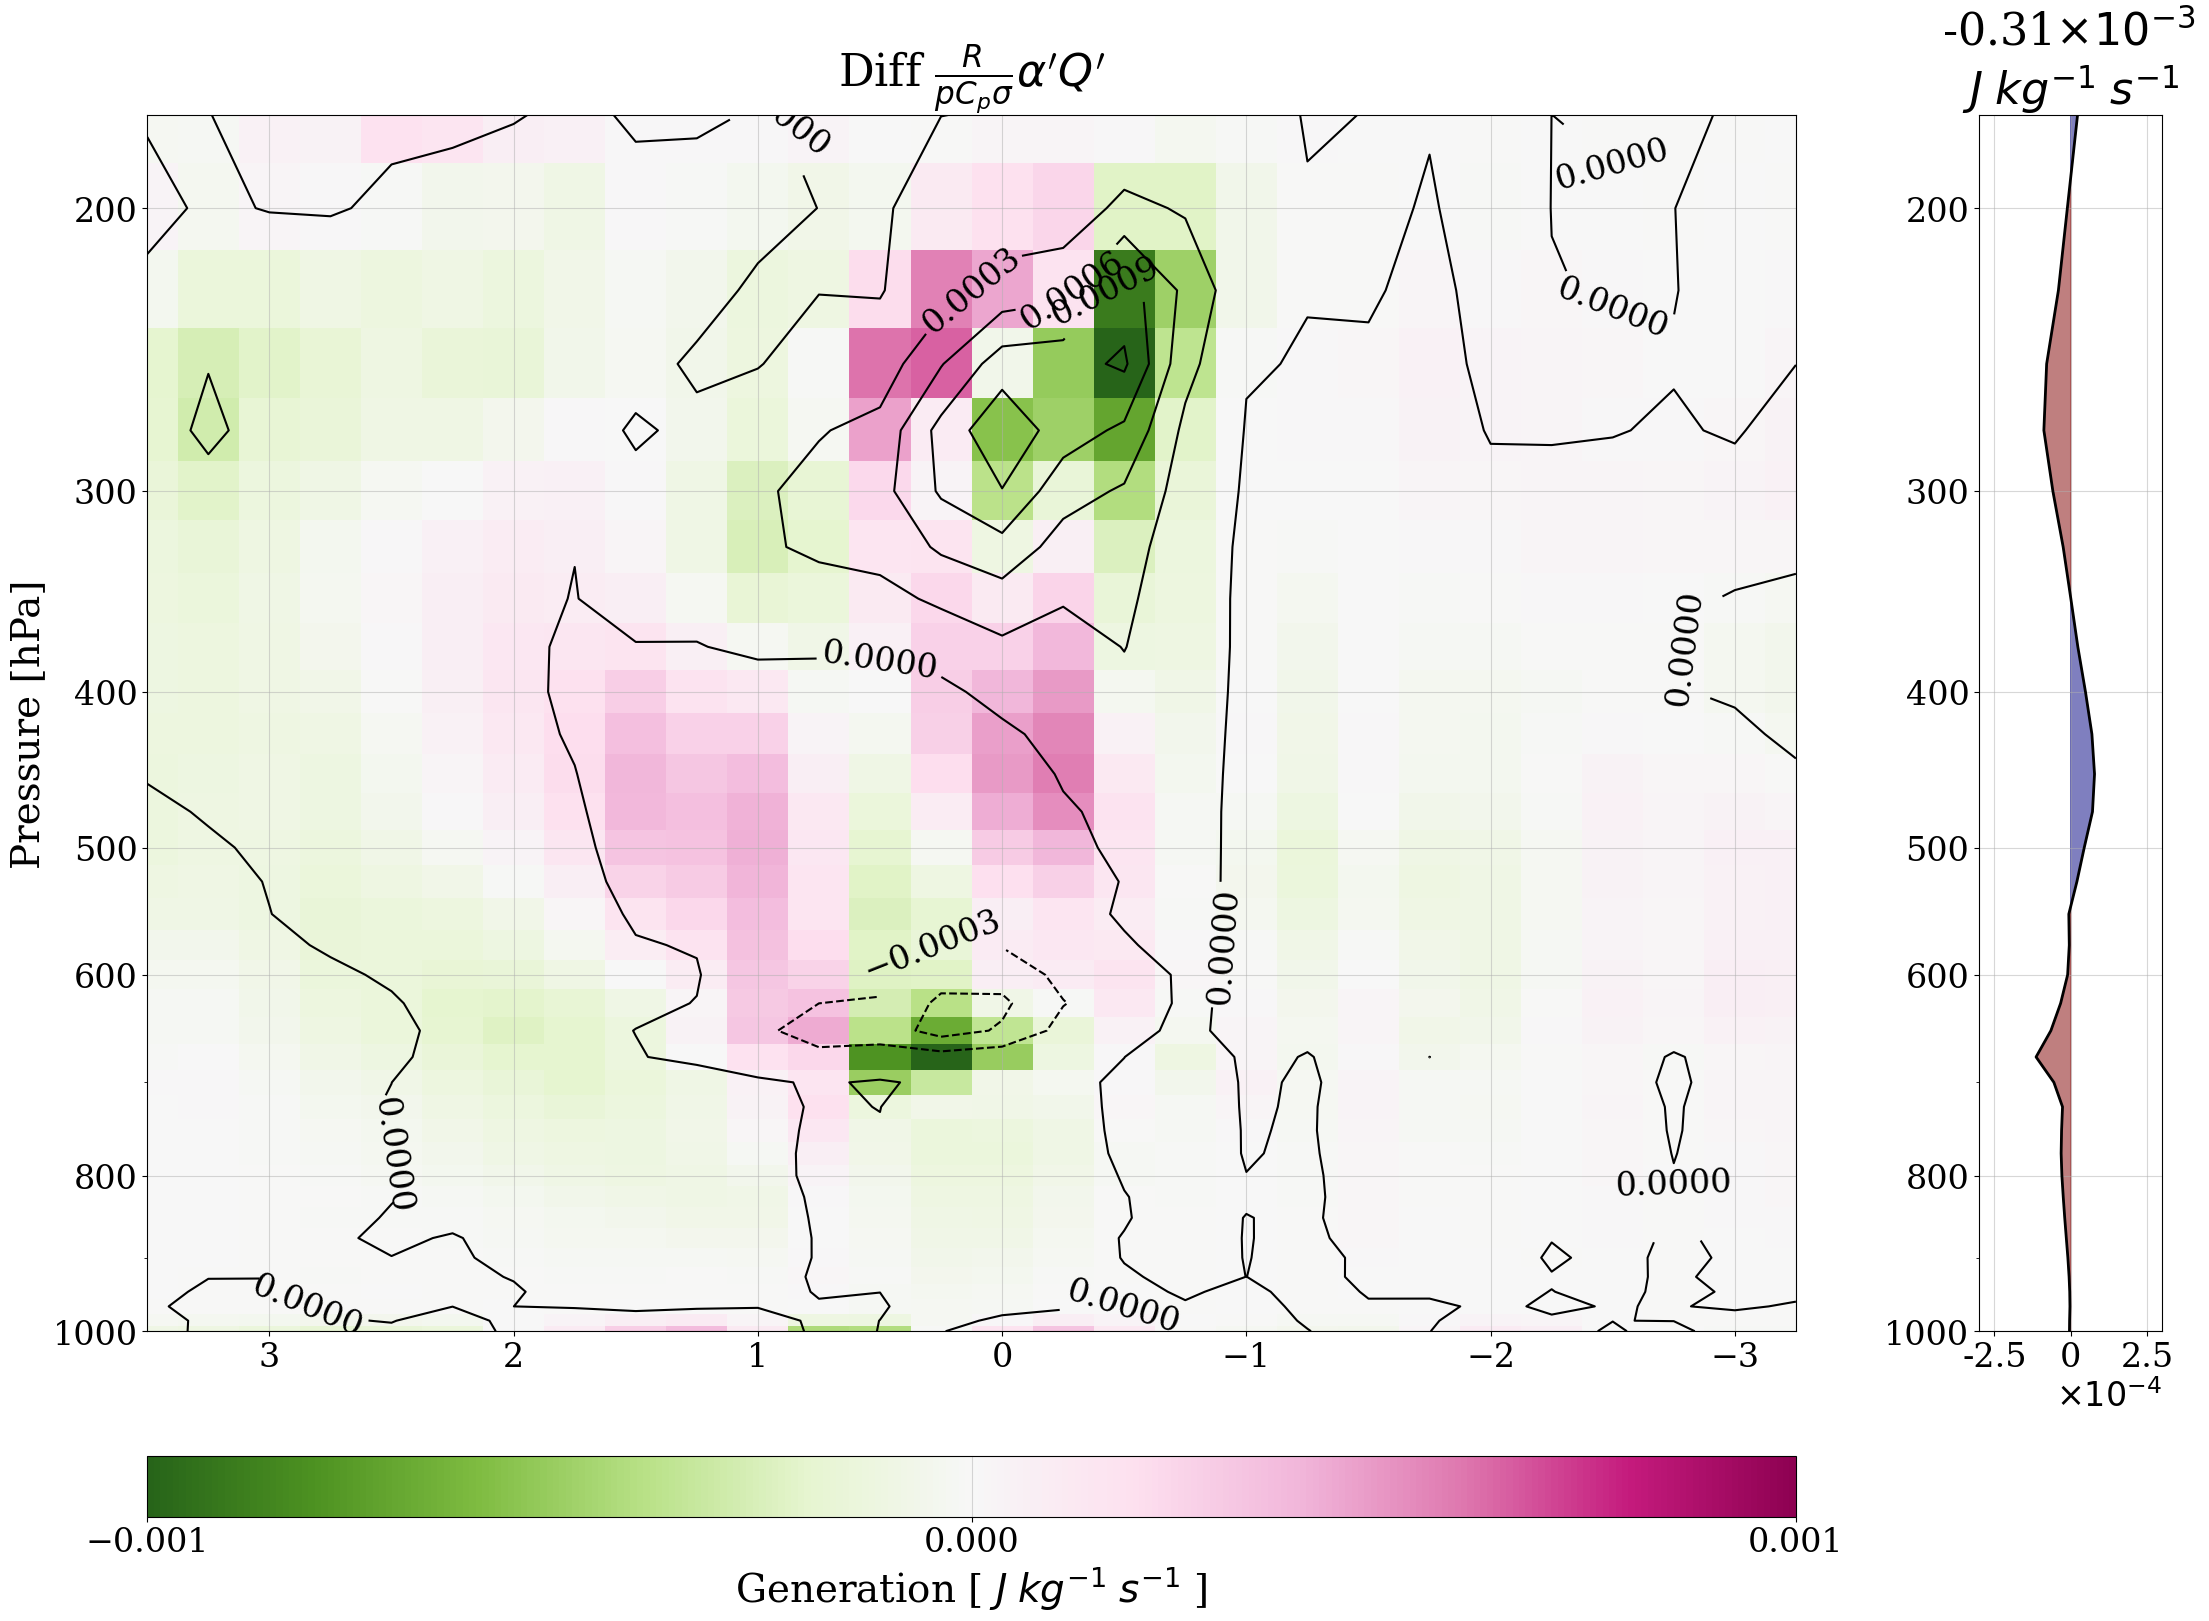

In [19]:
fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    gen["CNTL"][:z_lim],
    cmap="PiYG_r", norm=TwoSlopeNorm(0.0, vmin=-0.001, vmax=0.001),
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"CNTL $\frac{R}{p C_p \sigma} \alpha^\prime Q^\prime$")

gen_sum = vert_int(dims["lev"][:z_lim], gen['CNTL'].sum(axis=1)[:z_lim])
print(gen_sum)
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(gen["CNTL"].mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.fill_betweenx(z, 0, gen["CNTL"].mean(axis=1)[:z_lim], where=gen["CNTL"].mean(axis=1)[:z_lim] > 0, color="navy", alpha=0.5)
ax2.fill_betweenx(z, gen["CNTL"].mean(axis=1)[:z_lim], 0, where=gen["CNTL"].mean(axis=1)[:z_lim] < 0, color="maroon", alpha=0.5)
ax2.set_xticks(np.linspace(-2.5e-4, 2.5e-4, 3), ["-2.5", "0", "2.5"])
ax2.set_xlim(-3e-4, 3e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{gen_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Generation [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=[-0.001, 0, 0.001]
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Generation/CNTL.png", dpi=300)
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    gen["NCRF"][:z_lim],
    cmap="PiYG_r", norm=TwoSlopeNorm(0.0, vmin=-0.001, vmax=0.001),
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"NCRF $\frac{R}{p C_p \sigma} \alpha^\prime Q^\prime$")

gen_sum = vert_int(dims["lev"][:z_lim], gen['NCRF'].sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(gen["NCRF"].mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.fill_betweenx(
    z, 0, gen["NCRF"].mean(axis=1)[:z_lim],
    where=gen["NCRF"].mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, gen["NCRF"].mean(axis=1)[:z_lim], 0,
    where=gen["NCRF"].mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)
ax2.set_xticks(np.linspace(-2.5e-4, 2.5e-4, 3), ["-2.5", "0", "2.5"])
ax2.set_xlim(-3e-4, 3e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{gen_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Generation [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=np.linspace(-0.001, 0.001, 3)
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Generation/NCRF.png", dpi=300)
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    gen_diff[:z_lim],
    cmap="PiYG_r", norm=TwoSlopeNorm(0.0, vmin=-0.001, vmax=0.001),
)
ct = ax1.contour(
    xx, zz,
    gen["CNTL"][:z_lim], colors="k"
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"Diff $\frac{R}{p C_p \sigma} \alpha^\prime Q^\prime$")
plt.clabel(ct, inline=True)

gen_sum = vert_int(dims["lev"][:z_lim], gen_diff.sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(gen_diff.mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.fill_betweenx(
    z, 0, gen_diff.mean(axis=1)[:z_lim],
    where=gen_diff.mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, gen_diff.mean(axis=1)[:z_lim], 0,
    where=gen_diff.mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)
ax2.set_xticks(np.linspace(-2.5e-4, 2.5e-4, 3), ["-2.5", "0", "2.5"])
ax2.set_xlim(-3e-4, 3e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{gen_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Generation [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=np.linspace(-0.001, 0.001, 3)
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Generation/diff.png", dpi=300)
plt.show()
plt.close(fig)

#### EAPE conversion

(36,)


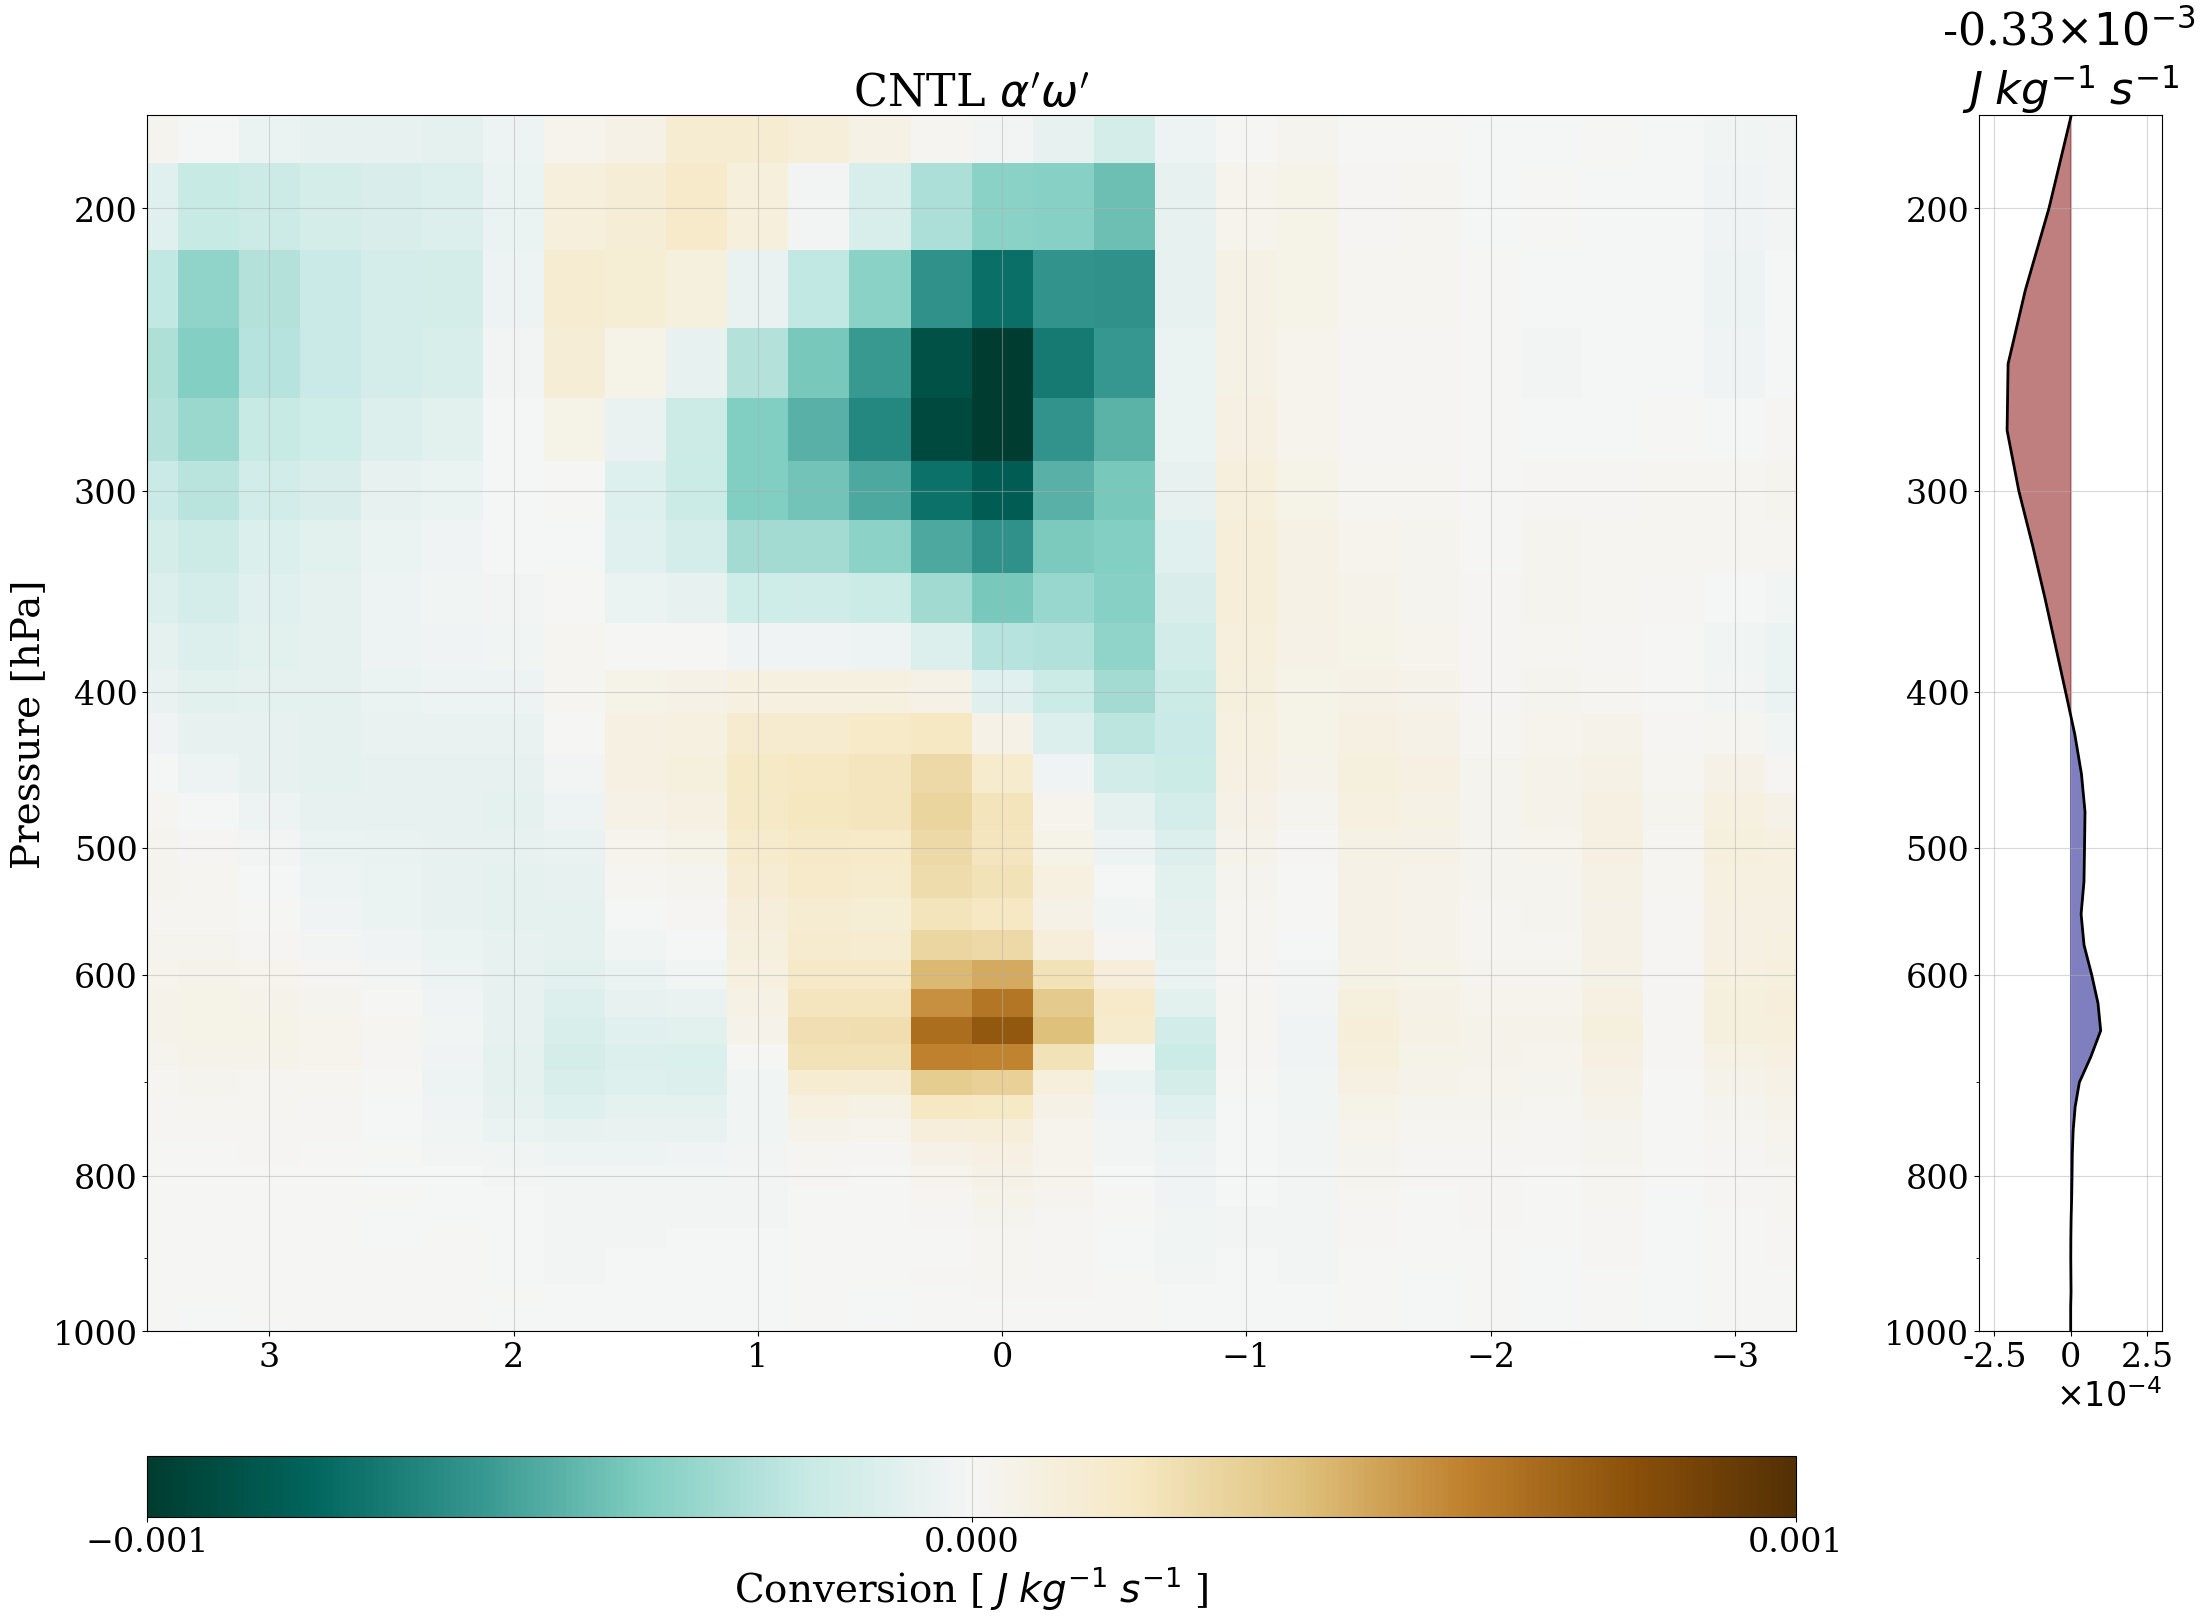

(36,)


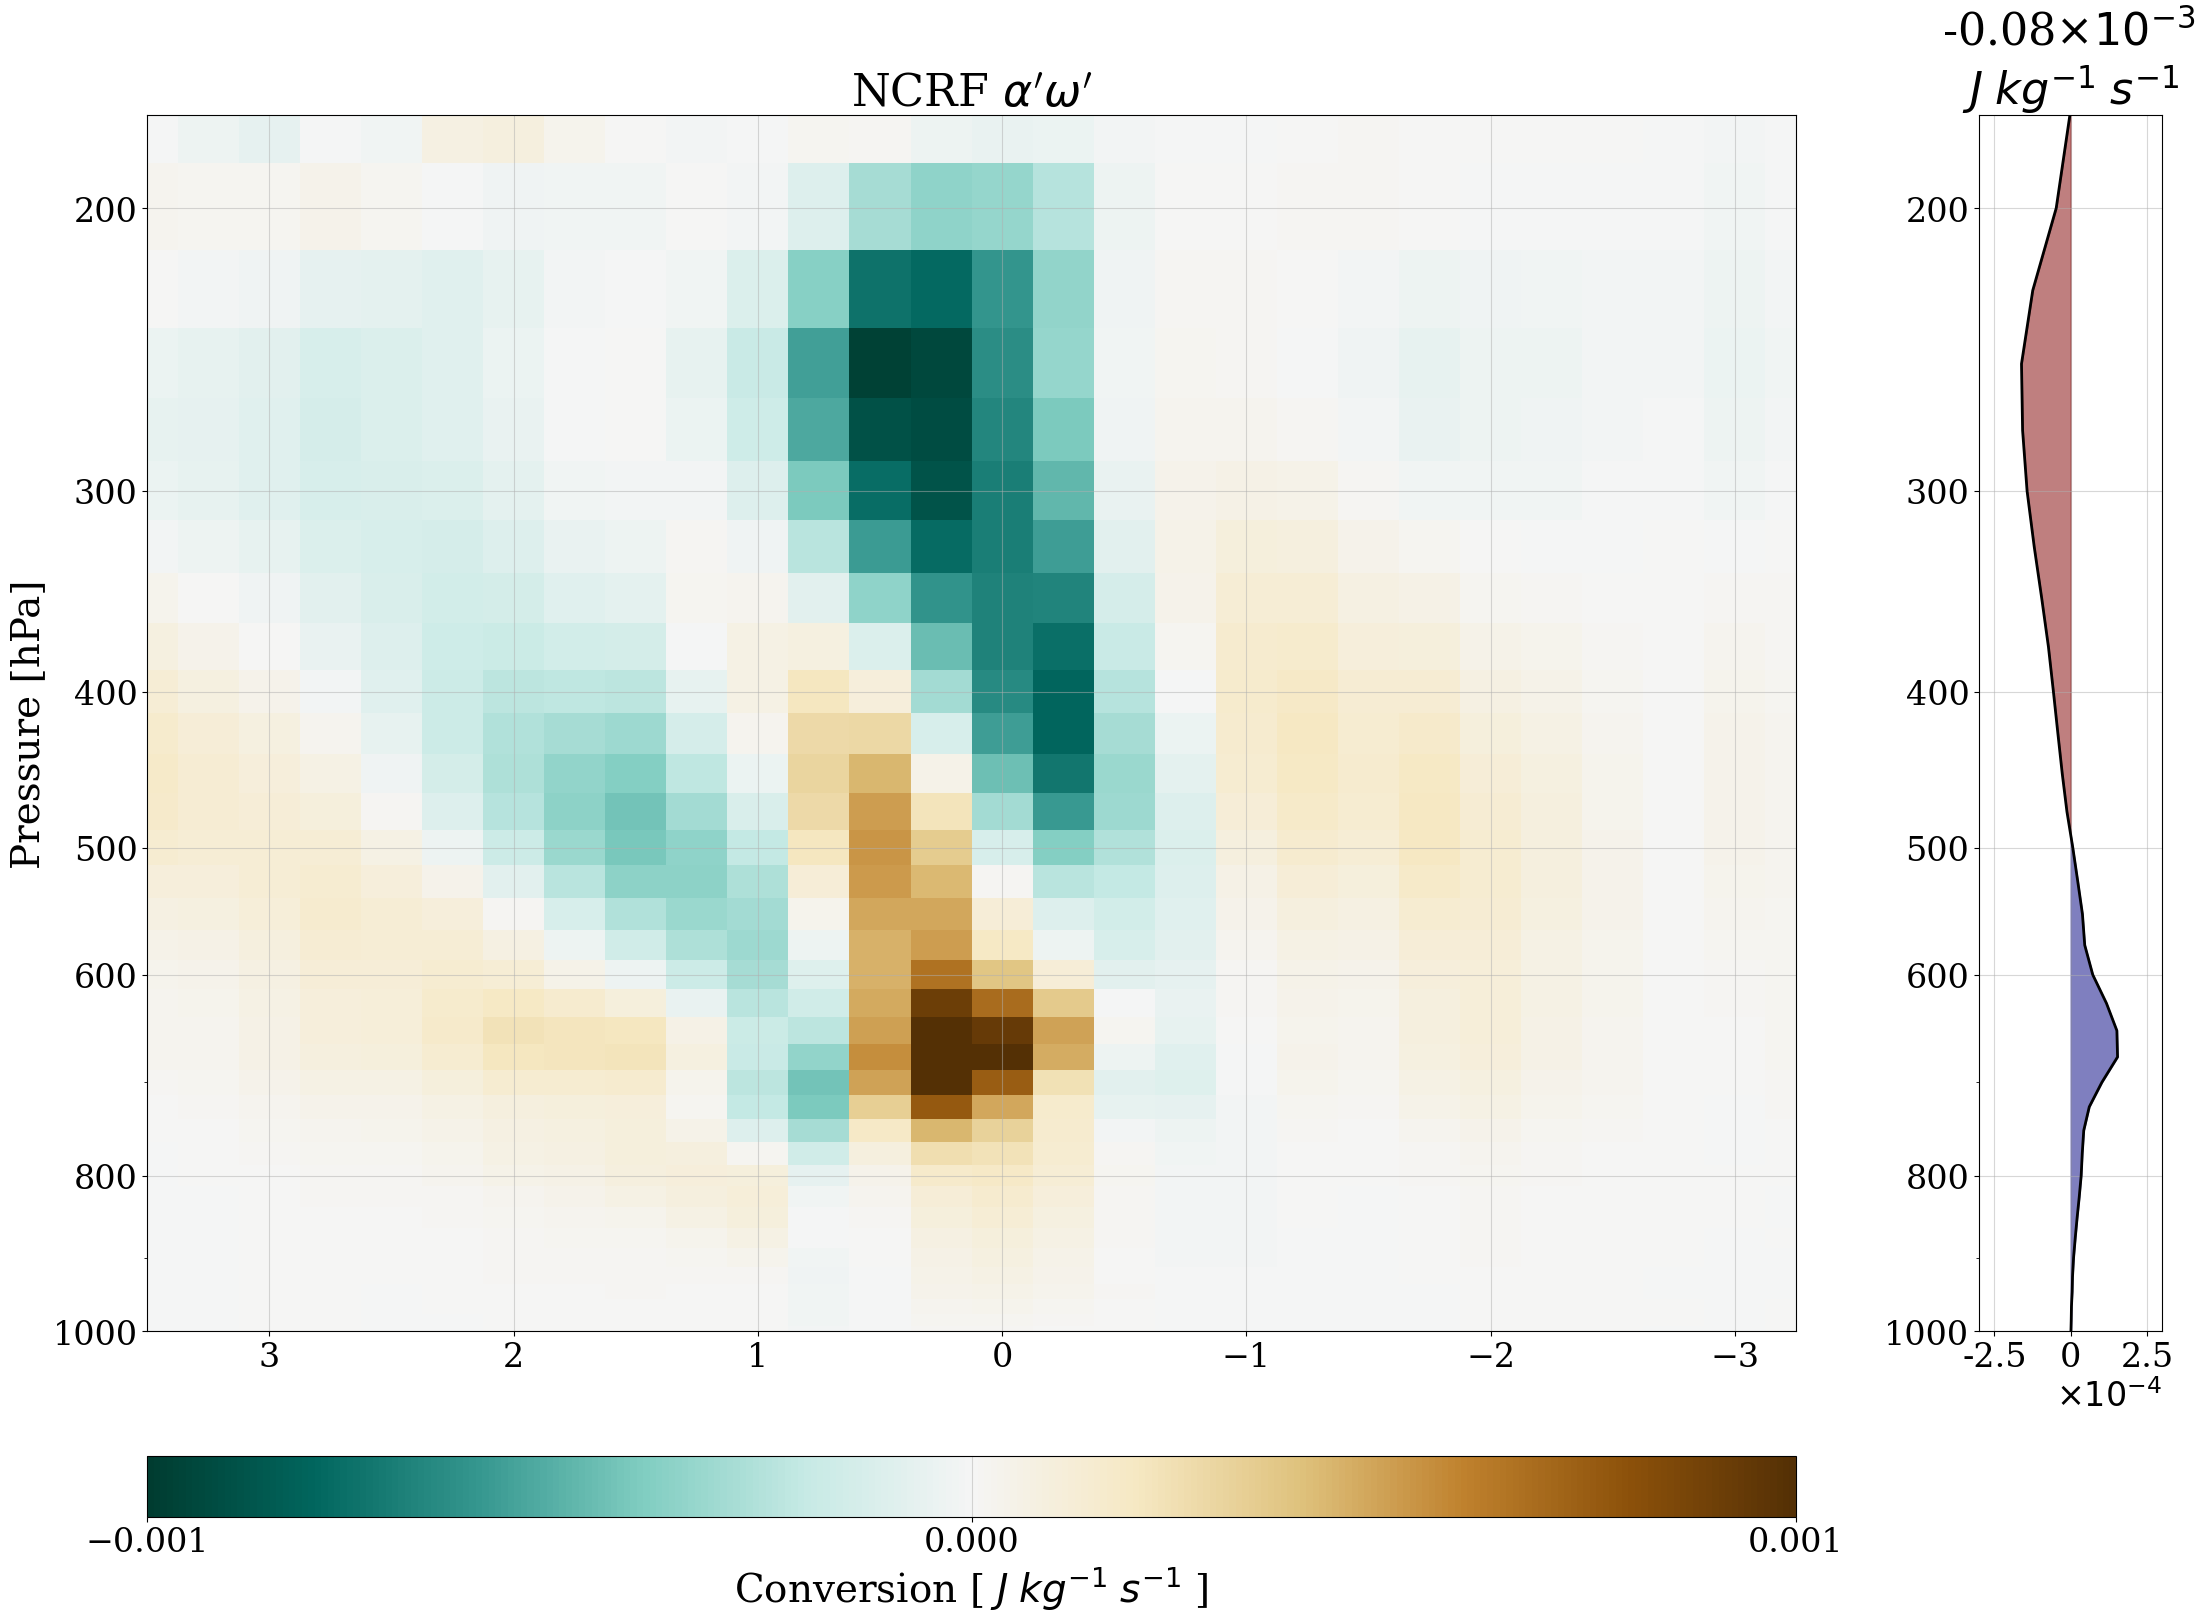

(36,)


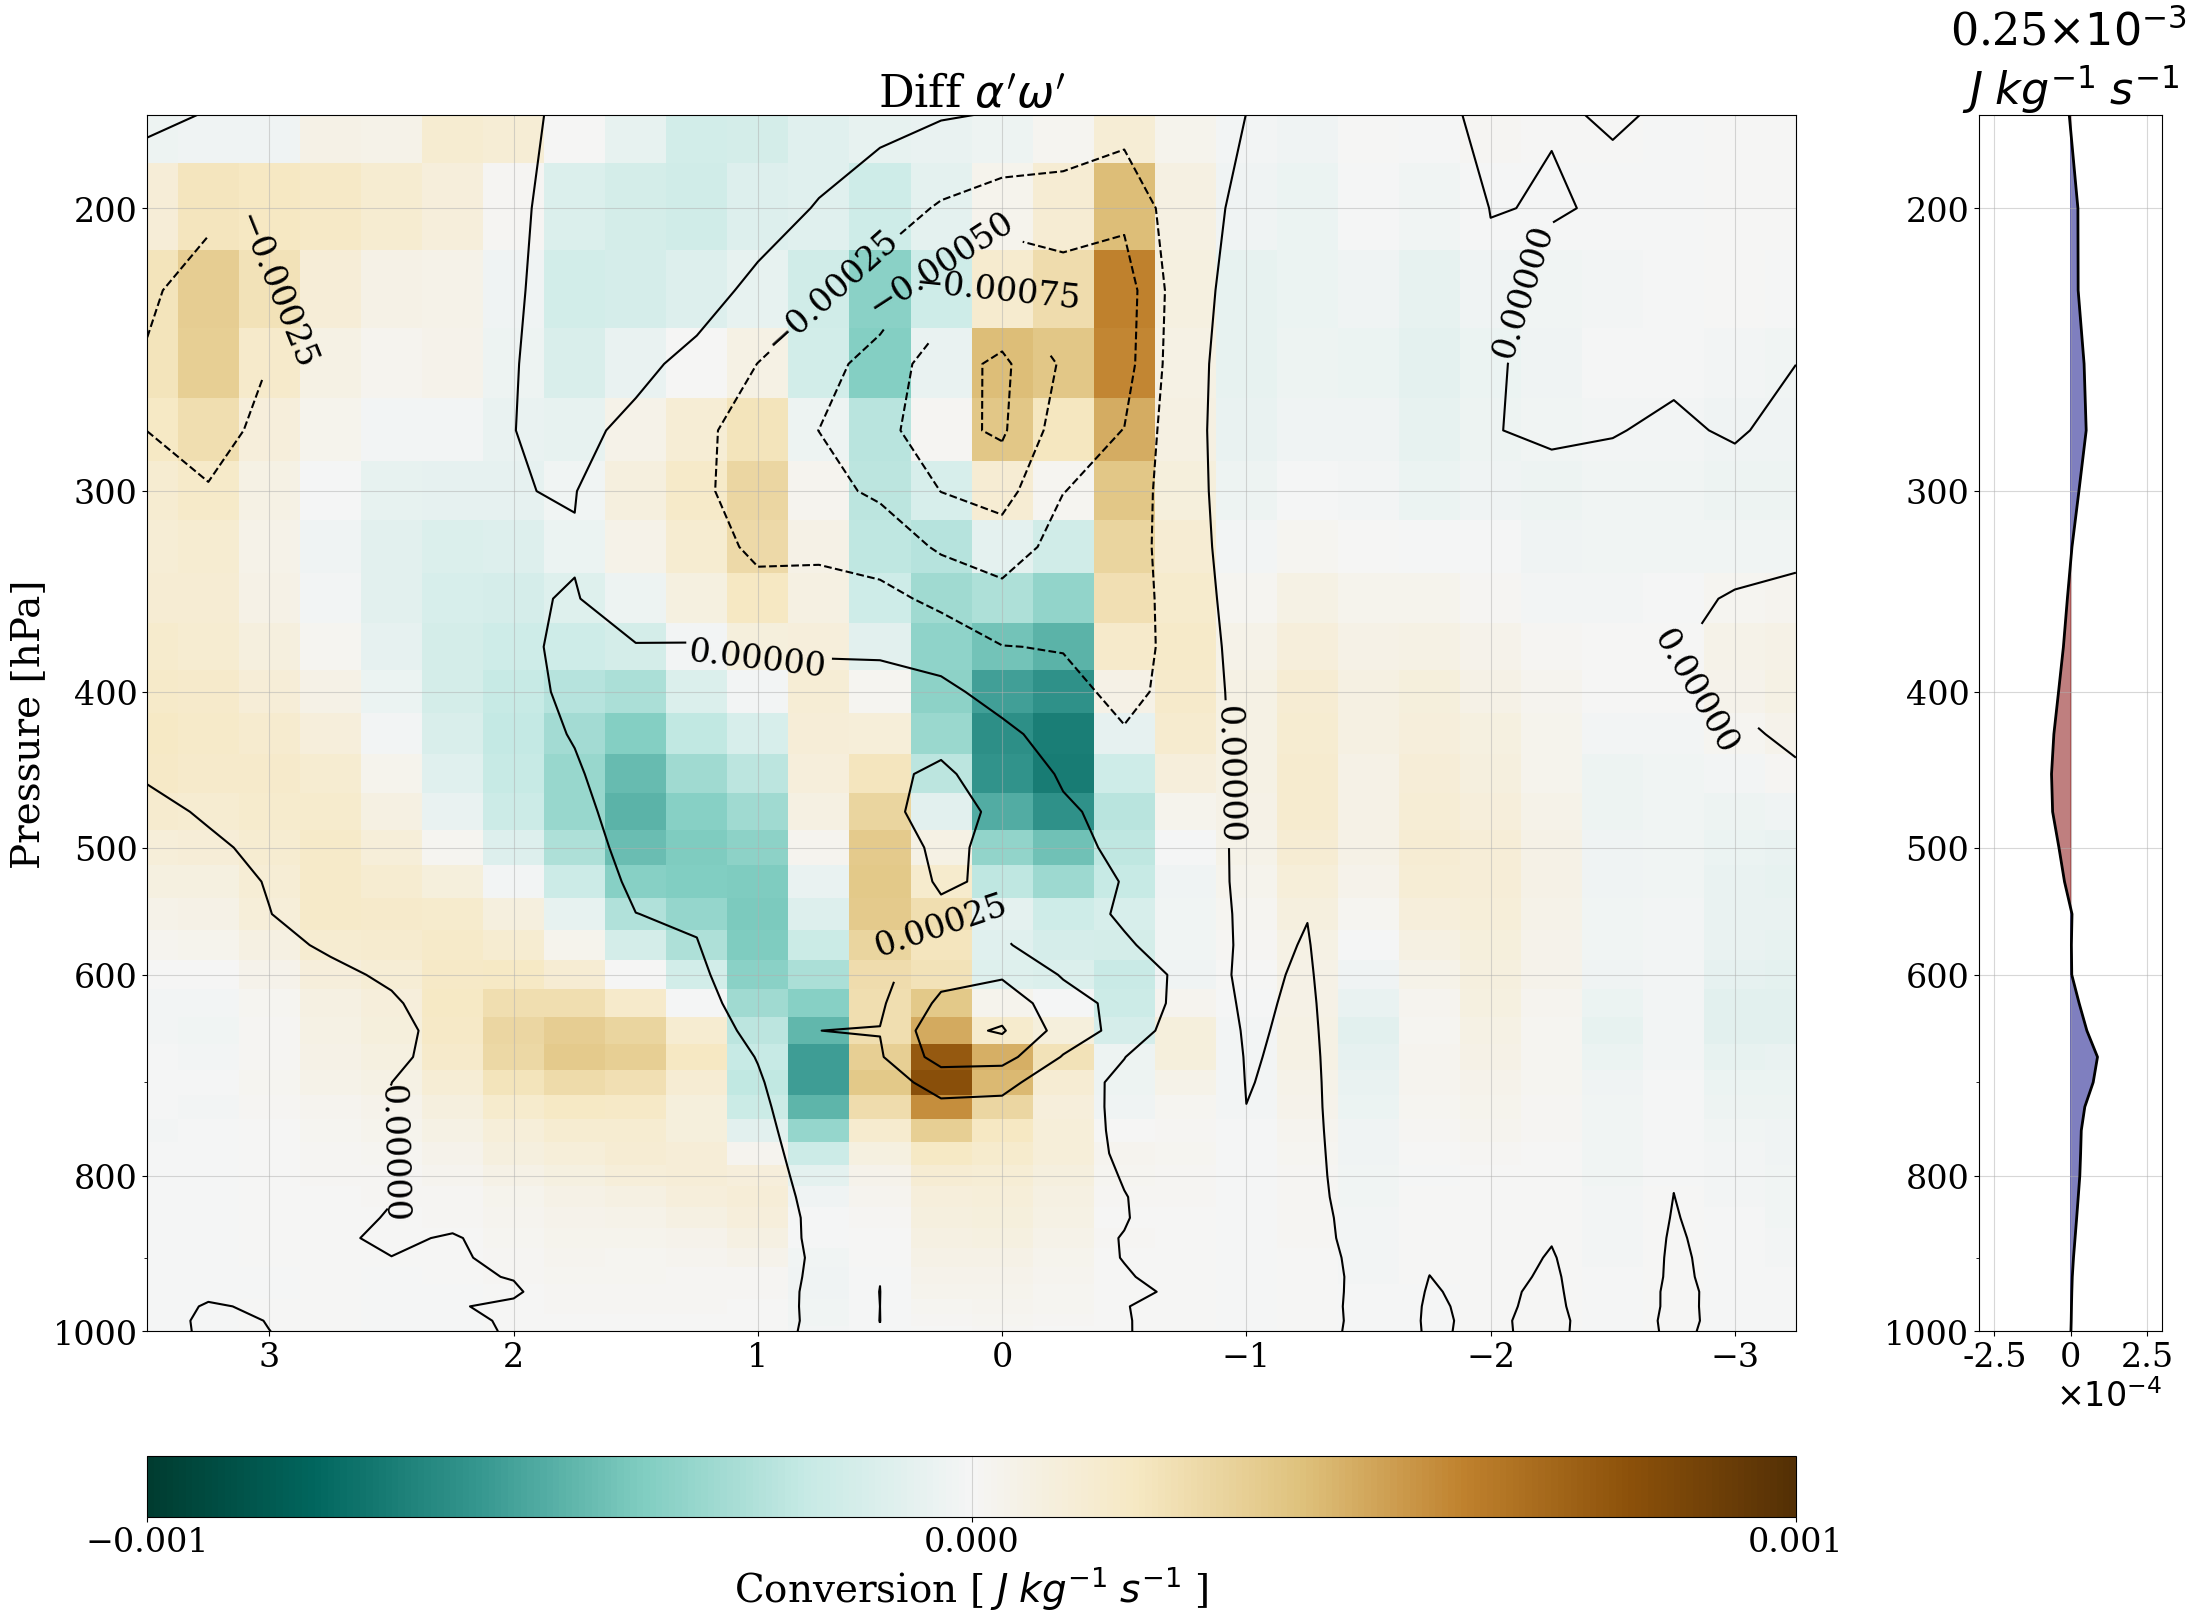

In [20]:
fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    conv["CNTL"][:z_lim],
    cmap="BrBG_r", norm=TwoSlopeNorm(0.0, vmin=-0.001, vmax=0.001),
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"CNTL $\alpha^\prime \omega^\prime$")

conv_sum = vert_int(dims["lev"][:z_lim], conv['CNTL'].sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(conv["CNTL"].mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(-2.5e-4, 2.5e-4, 3), ["-2.5", "0", "2.5"])
ax2.set_xlim(-3e-4, 3e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{conv_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")
ax2.fill_betweenx(
    z, 0, conv["CNTL"].mean(axis=1)[:z_lim],
    where=conv["CNTL"].mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, conv["CNTL"].mean(axis=1)[:z_lim], 0,
    where=conv["CNTL"].mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Conversion [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=[-0.001, 0, 0.001]
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Conversion/CNTL.png", dpi=300)
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    conv["NCRF"][:z_lim],
    cmap="BrBG_r", norm=TwoSlopeNorm(0.0, vmin=-0.001, vmax=0.001),
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"NCRF $\alpha^\prime \omega^\prime$")

conv_sum = vert_int(dims["lev"][:z_lim], conv['NCRF'].sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(conv["NCRF"].mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(-2.5e-4, 2.5e-4, 3), ["-2.5", "0", "2.5"])
ax2.set_xlim(-3e-4, 3e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{conv_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")
ax2.fill_betweenx(
    z, 0, conv["NCRF"].mean(axis=1)[:z_lim],
    where=conv["NCRF"].mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, conv["NCRF"].mean(axis=1)[:z_lim], 0,
    where=conv["NCRF"].mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Conversion [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=np.linspace(-0.001, 0.001, 3)
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Conversion/NCRF.png", dpi=300)
plt.show()
plt.close(fig)



fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    conv_diff[:z_lim],
    cmap="BrBG_r", norm=TwoSlopeNorm(0.0, vmin=-0.001, vmax=0.001),
)
ct = ax1.contour(
    xx, zz,
    conv["CNTL"][:z_lim],
    colors="k", 
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"Diff $\alpha^\prime \omega^\prime$")
plt.clabel(ct, inline=True)

conv_sum = vert_int(dims["lev"][:z_lim], conv_diff.sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(conv_diff.mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(-2.5e-4, 2.5e-4, 3), ["-2.5", "0", "2.5"])
ax2.set_xlim(-3e-4, 3e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{conv_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")
ax2.fill_betweenx(
    z, 0, conv_diff.mean(axis=1)[:z_lim],
    where=conv_diff.mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, conv_diff.mean(axis=1)[:z_lim], 0,
    where=conv_diff.mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Conversion [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=np.linspace(-0.001, 0.001, 3)
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Conversion/diff.png", dpi=300)
plt.show()
plt.close(fig)

#### Variance

(36,)


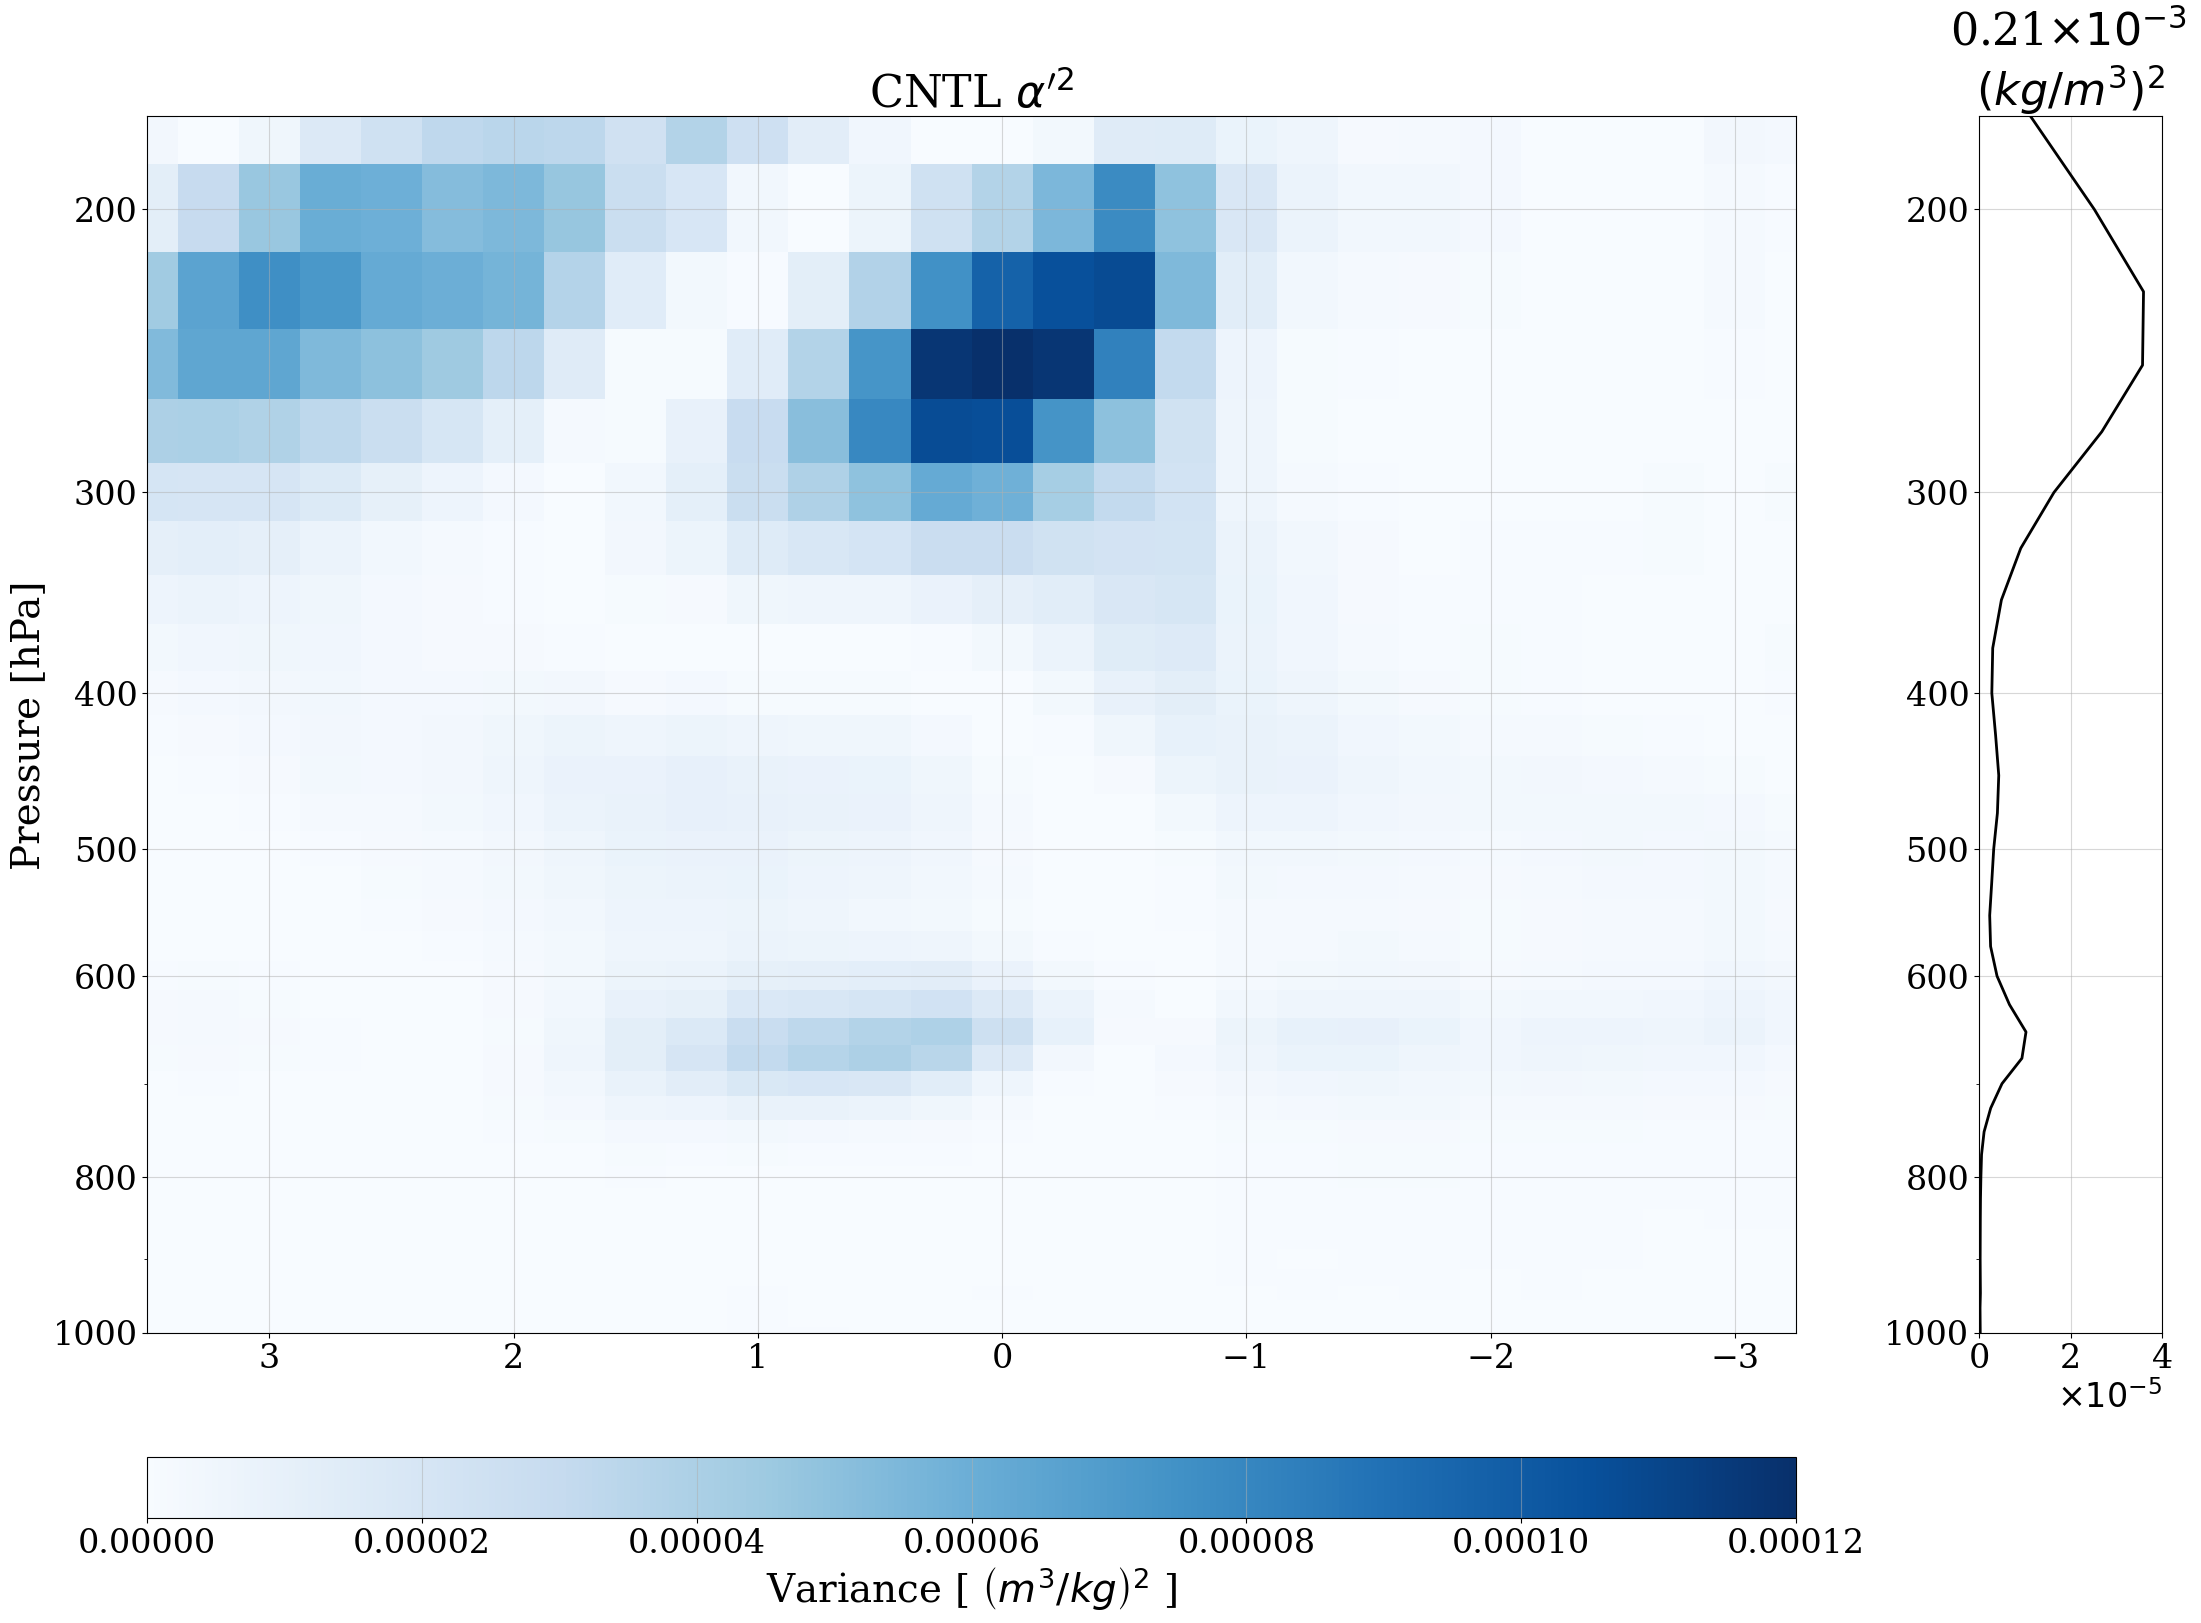

(36,)


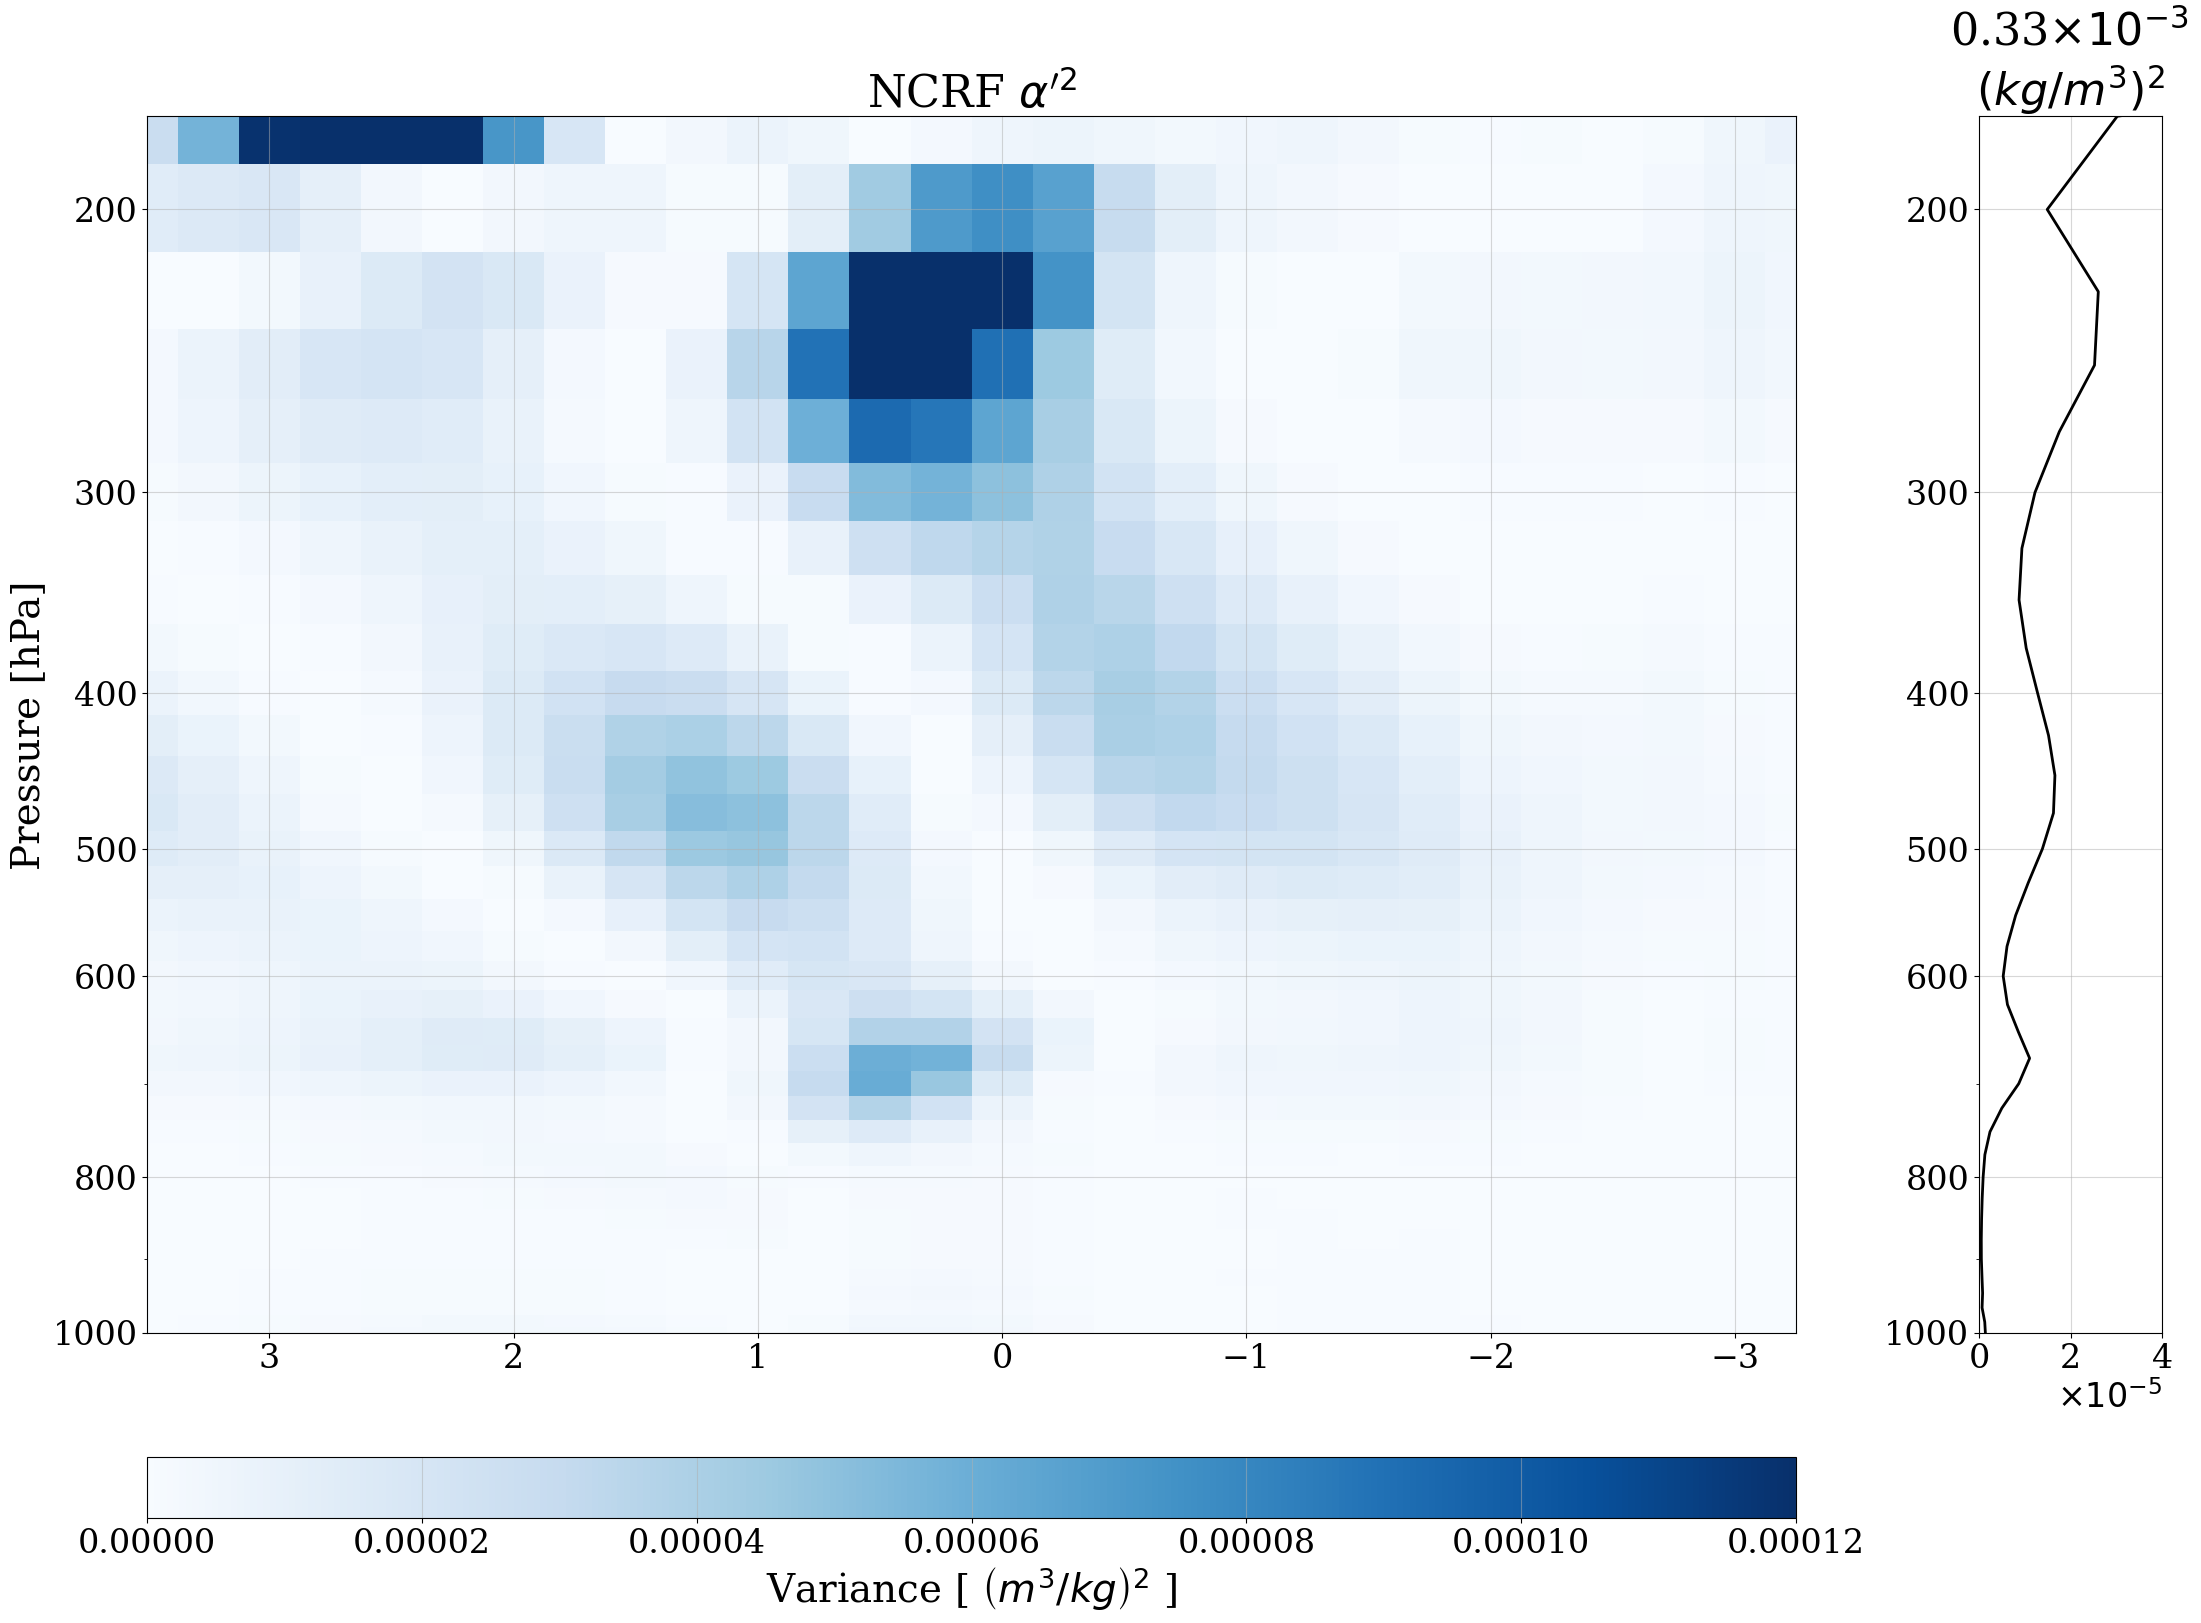

(36,)


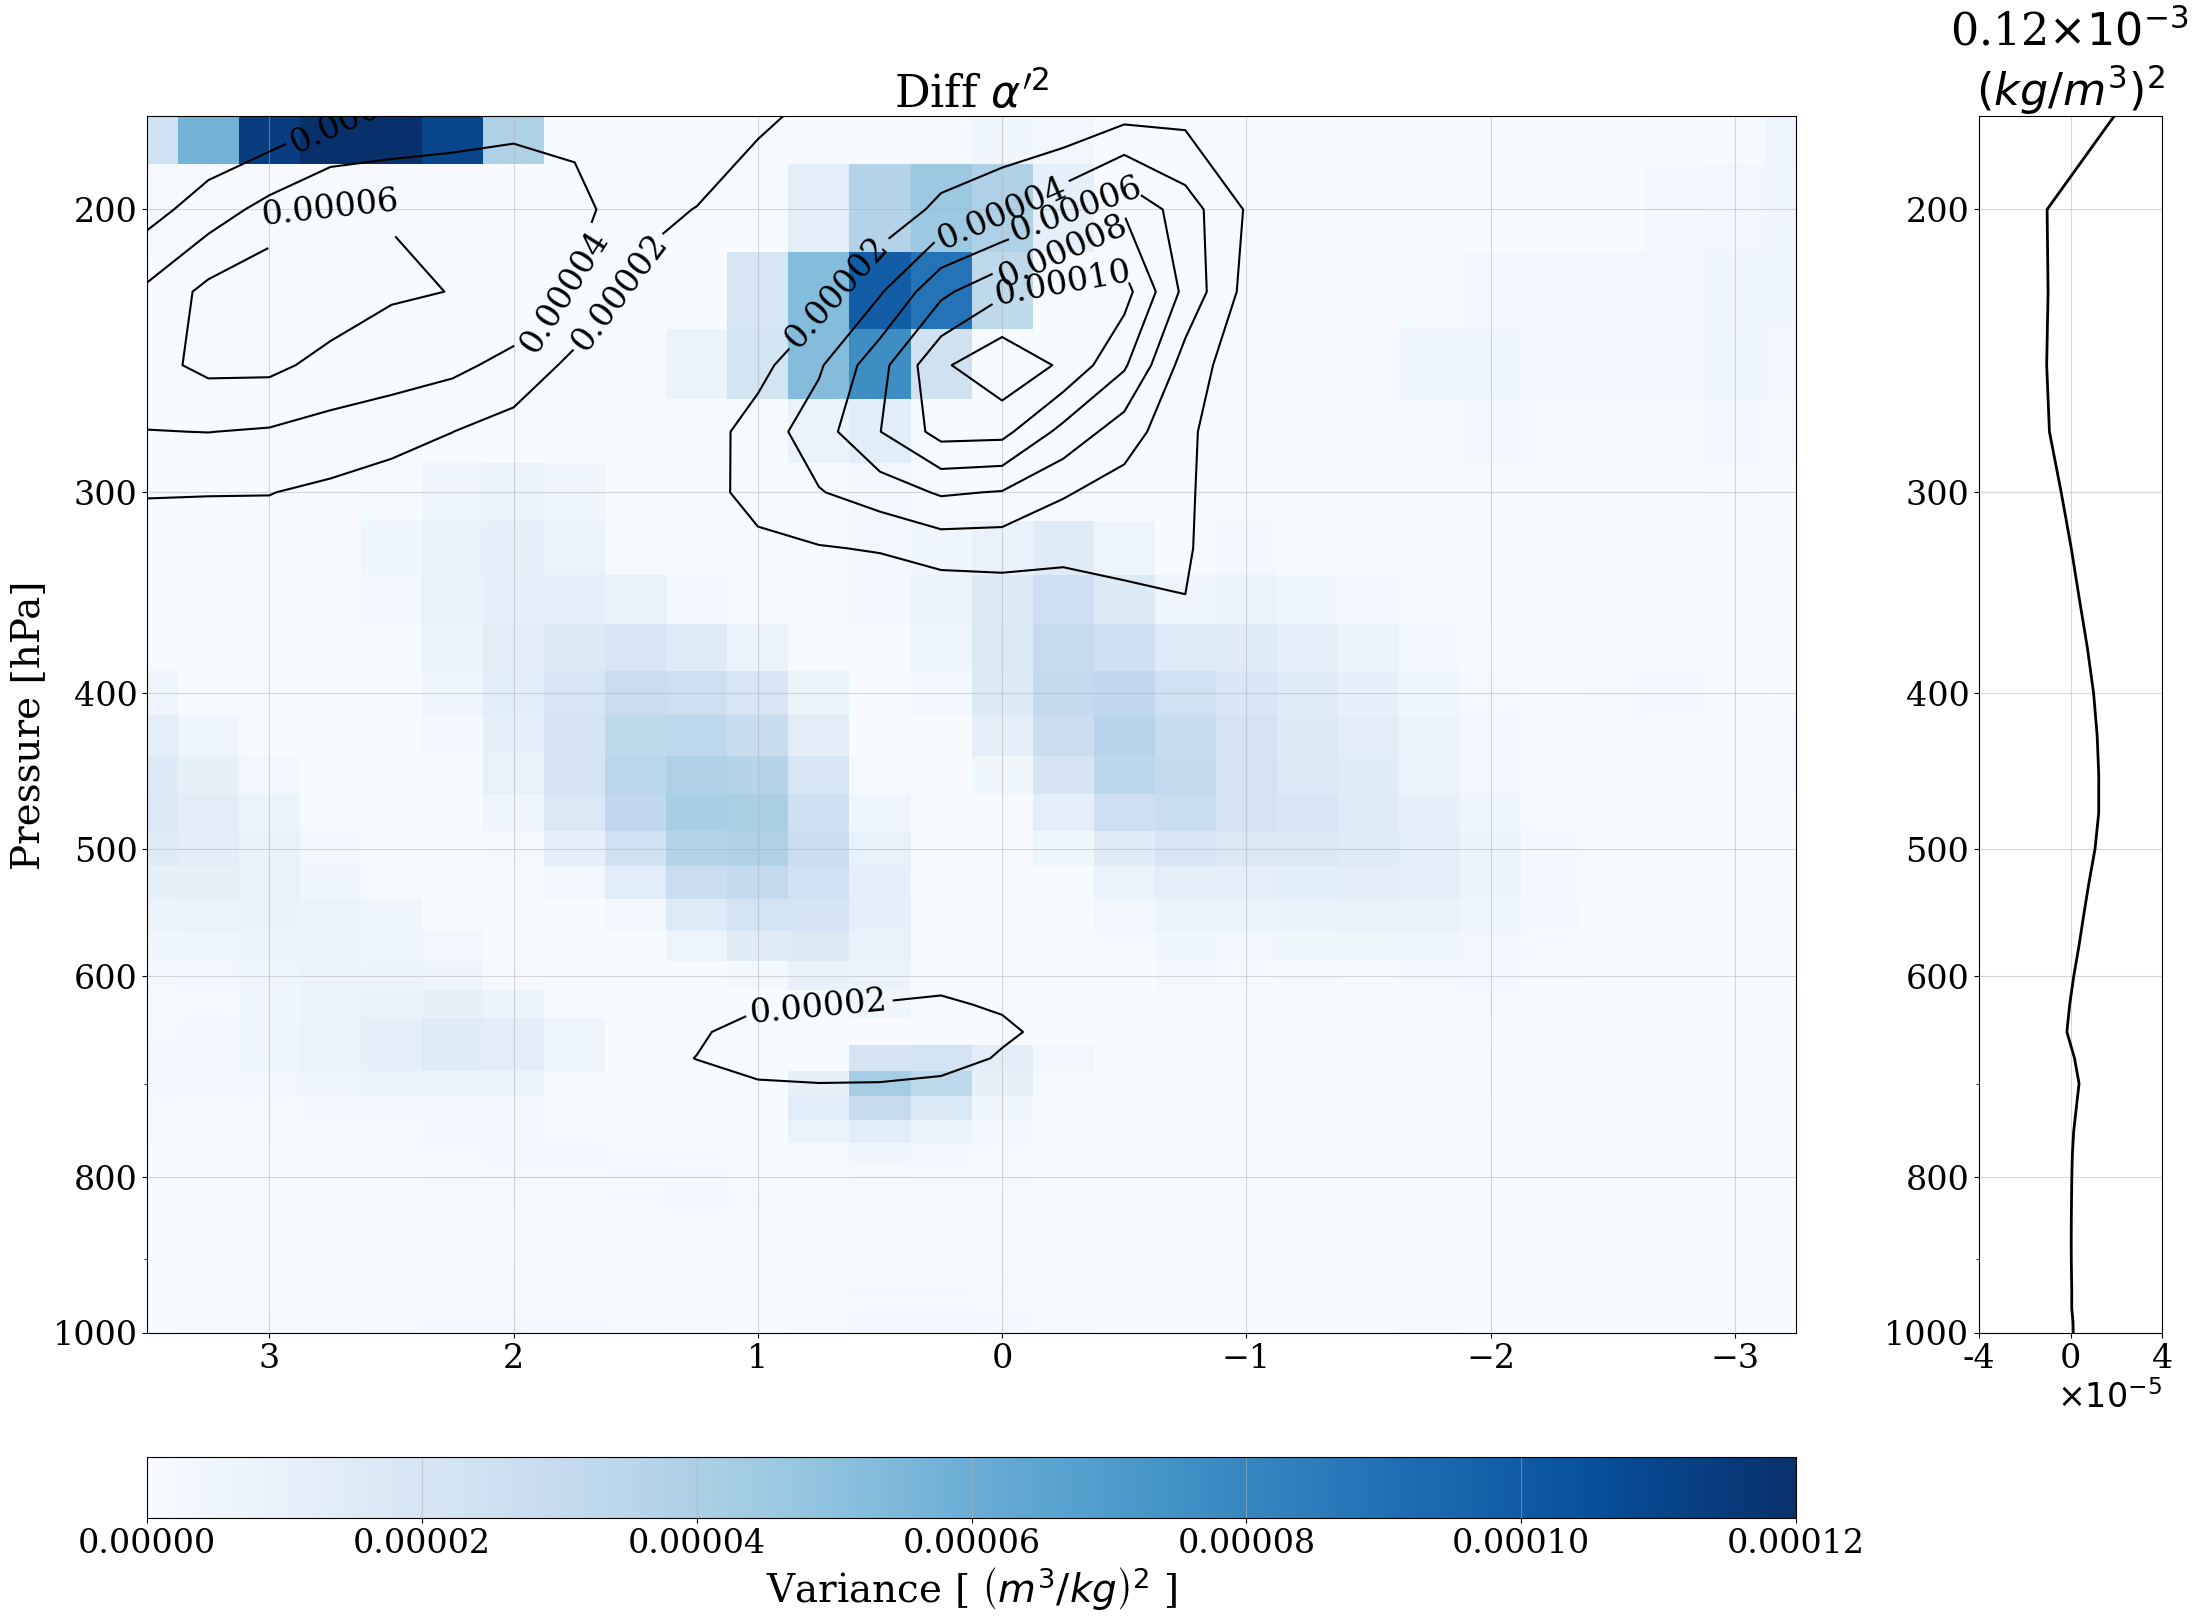

In [21]:
fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    a_var["CNTL"][:z_lim],
    cmap="Blues", vmin=0, vmax=0.00012
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"CNTL $\alpha^{\prime 2}$")

var_sum = vert_int(dims["lev"][:z_lim], a_var['CNTL'].sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(a_var["CNTL"].mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(0, 4e-5, 3), ["0", "2", "4"])
ax2.set_xlim(0, 4e-5)
ax2.set_ylim(1000, 175)
ax2.set_title(f"{var_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$(kg/m^3)^2$")
ax2.set_xlabel(r"$\times 10^{-5}$", fontsize=24, loc="right")

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Variance [ $\left( m^3 / kg \right)^2$ ]",
    # ticks=[0, 1.2]
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Variance/CNTL.png", dpi=300)
plt.show()
plt.close(fig)


fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    a_var["NCRF"][:z_lim],
    cmap="Blues", vmin=0, vmax=0.00012
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"NCRF $\alpha^{\prime 2}$")

var_sum = vert_int(dims["lev"][:z_lim], a_var['NCRF'].sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(a_var["NCRF"].mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(0, 4e-5, 3), ["0", "2", "4"])
ax2.set_xlim(0, 4e-5)
ax2.set_ylim(1000, 175)
ax2.set_title(f"{var_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$(kg/m^3)^2$")
ax2.set_xlabel(r"$\times 10^{-5}$", fontsize=24, loc="right")

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Variance [ $\left( m^3 / kg \right)^2$ ]",
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Variance/NCRF.png", dpi=300)
plt.show()
plt.close(fig)


fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    var_diff[:z_lim],
    cmap="Blues", vmin=0, vmax=0.00012
)
ct = ax1.contour(
    xx, zz,
    a_var["CNTL"][:z_lim], colors="k"
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"Diff $\alpha^{\prime 2}$")
plt.clabel(ct, inline=True)

var_sum = vert_int(dims["lev"][:z_lim], var_diff.sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(var_diff.mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(-4e-5, 4e-5, 3), ["-4", "0", "4"])
ax2.set_xlim(-4e-5, 4e-5)
ax2.set_ylim(1000, 175)
ax2.set_title(f"{var_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$(kg/m^3)^2$")
ax2.set_xlabel(r"$\times 10^{-5}$", fontsize=24, loc="right")

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Variance [ $\left( m^3 / kg \right)^2$ ]",
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Variance/diff.png", dpi=300)
plt.show()
plt.close(fig)


#### Variance tendency

(36,)


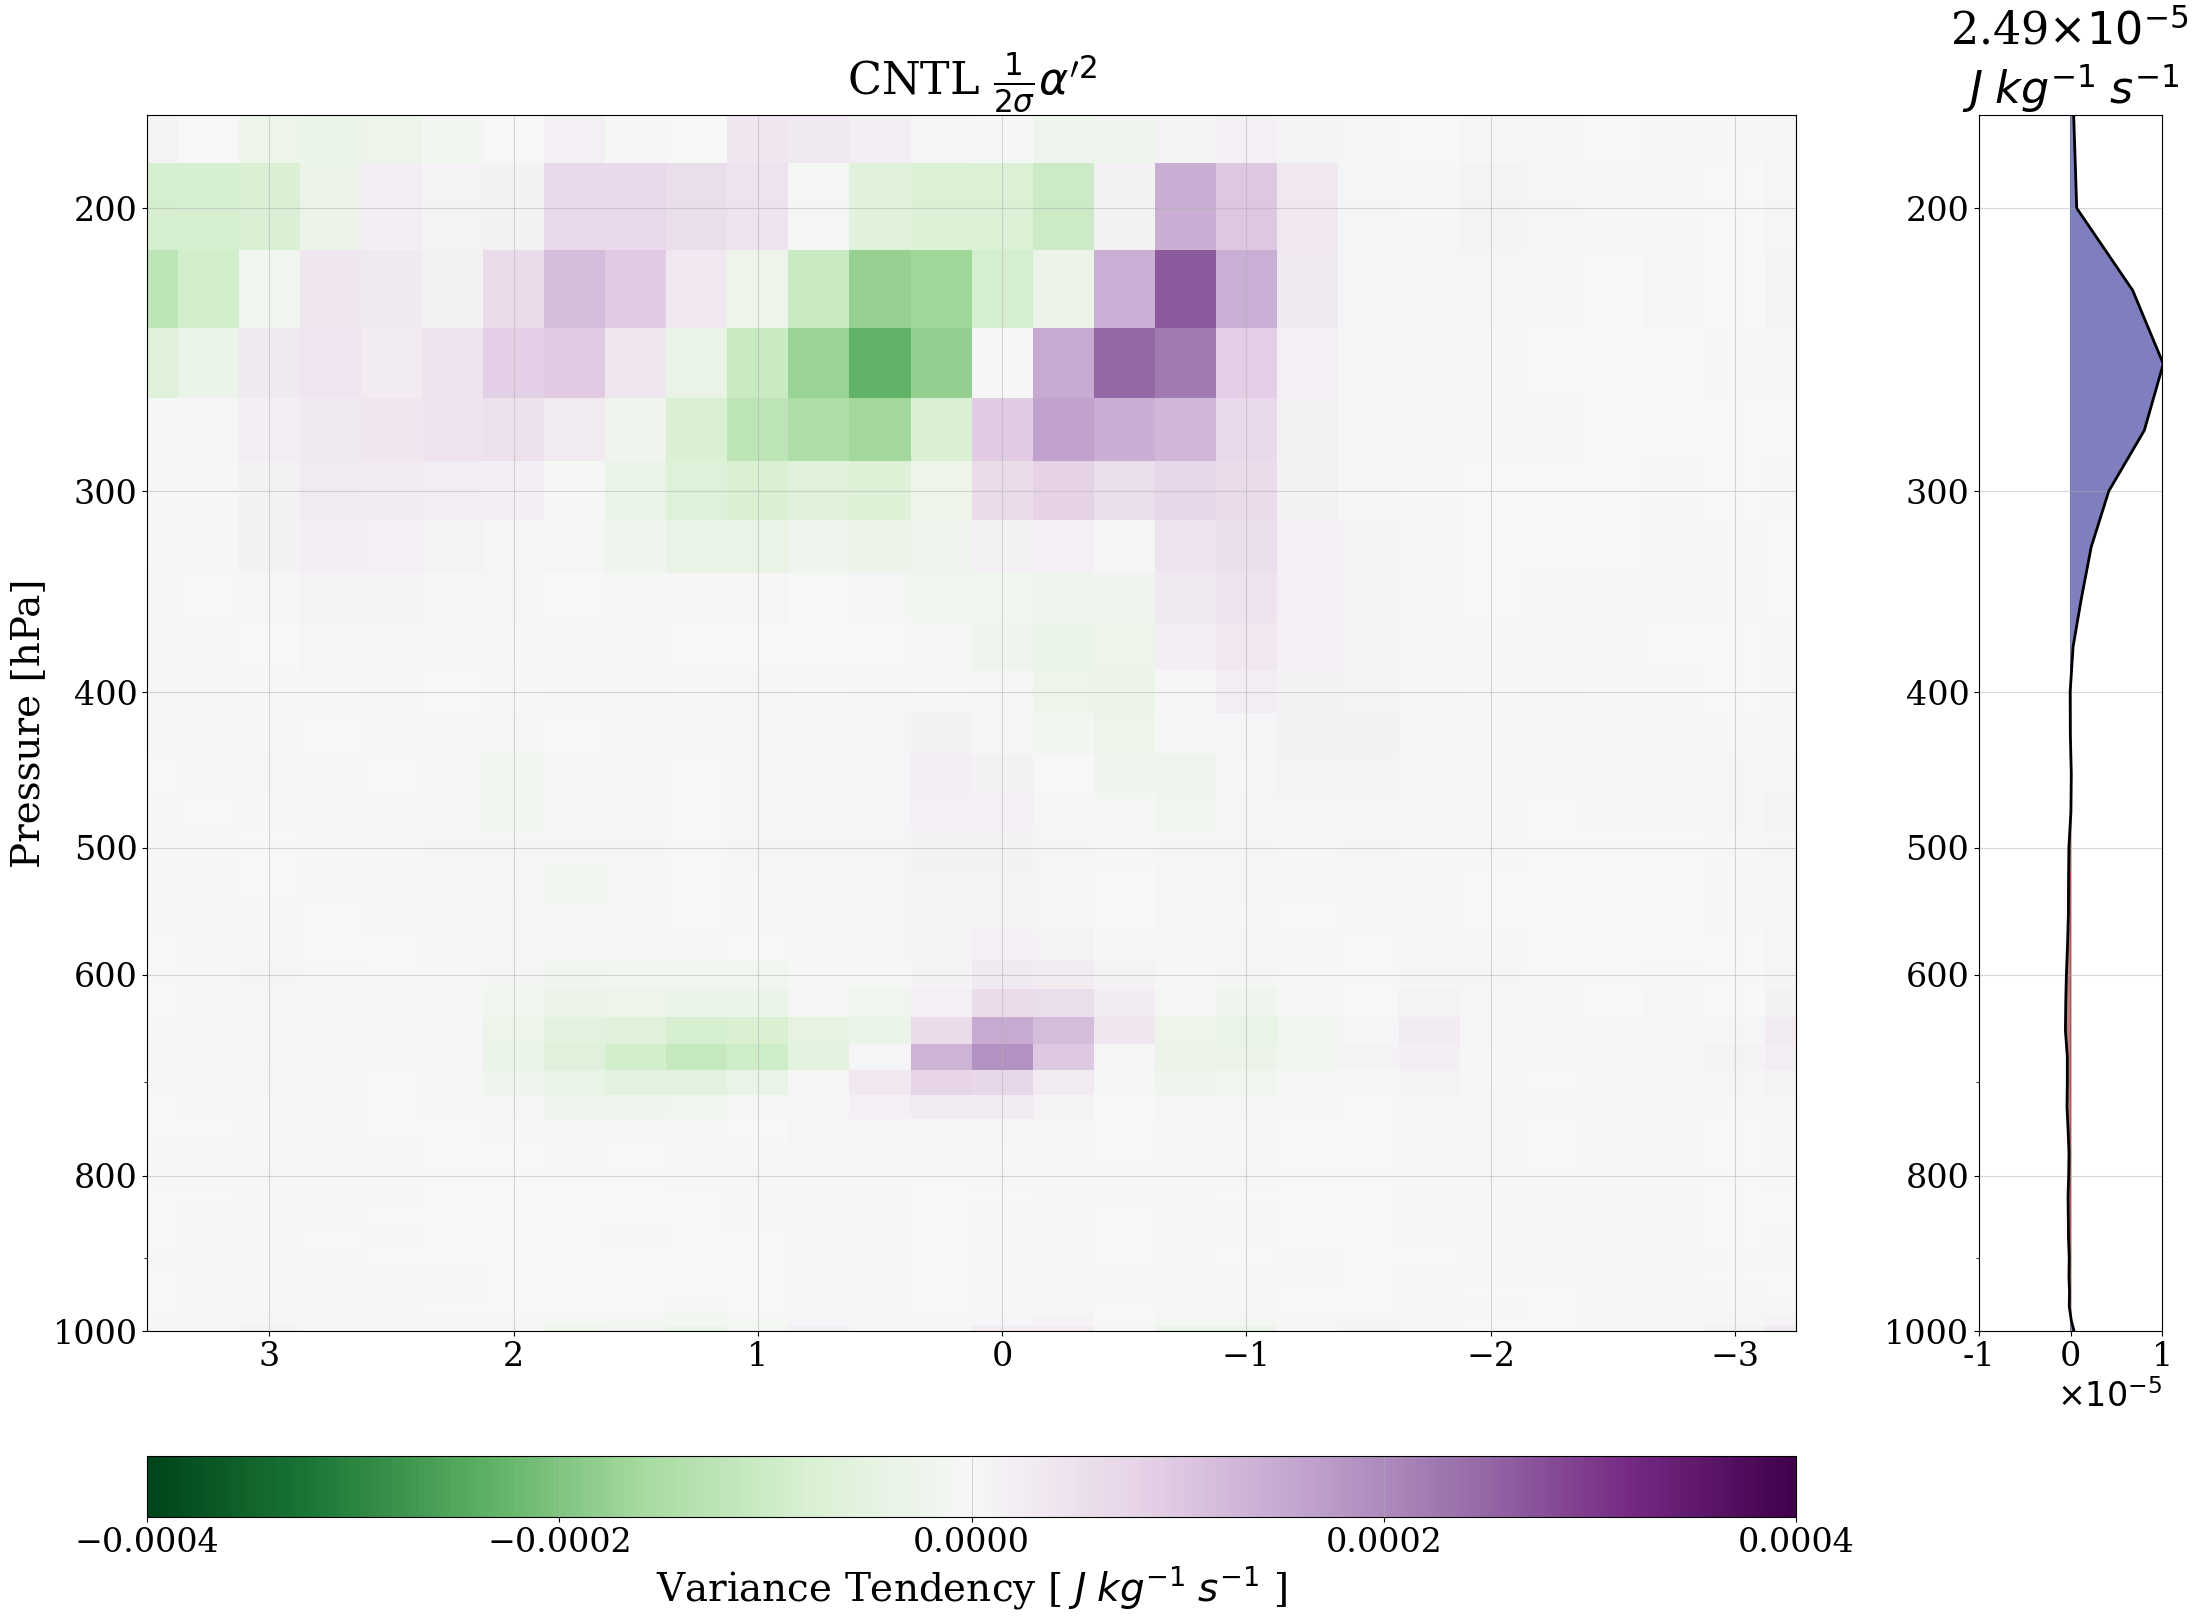

(36,)


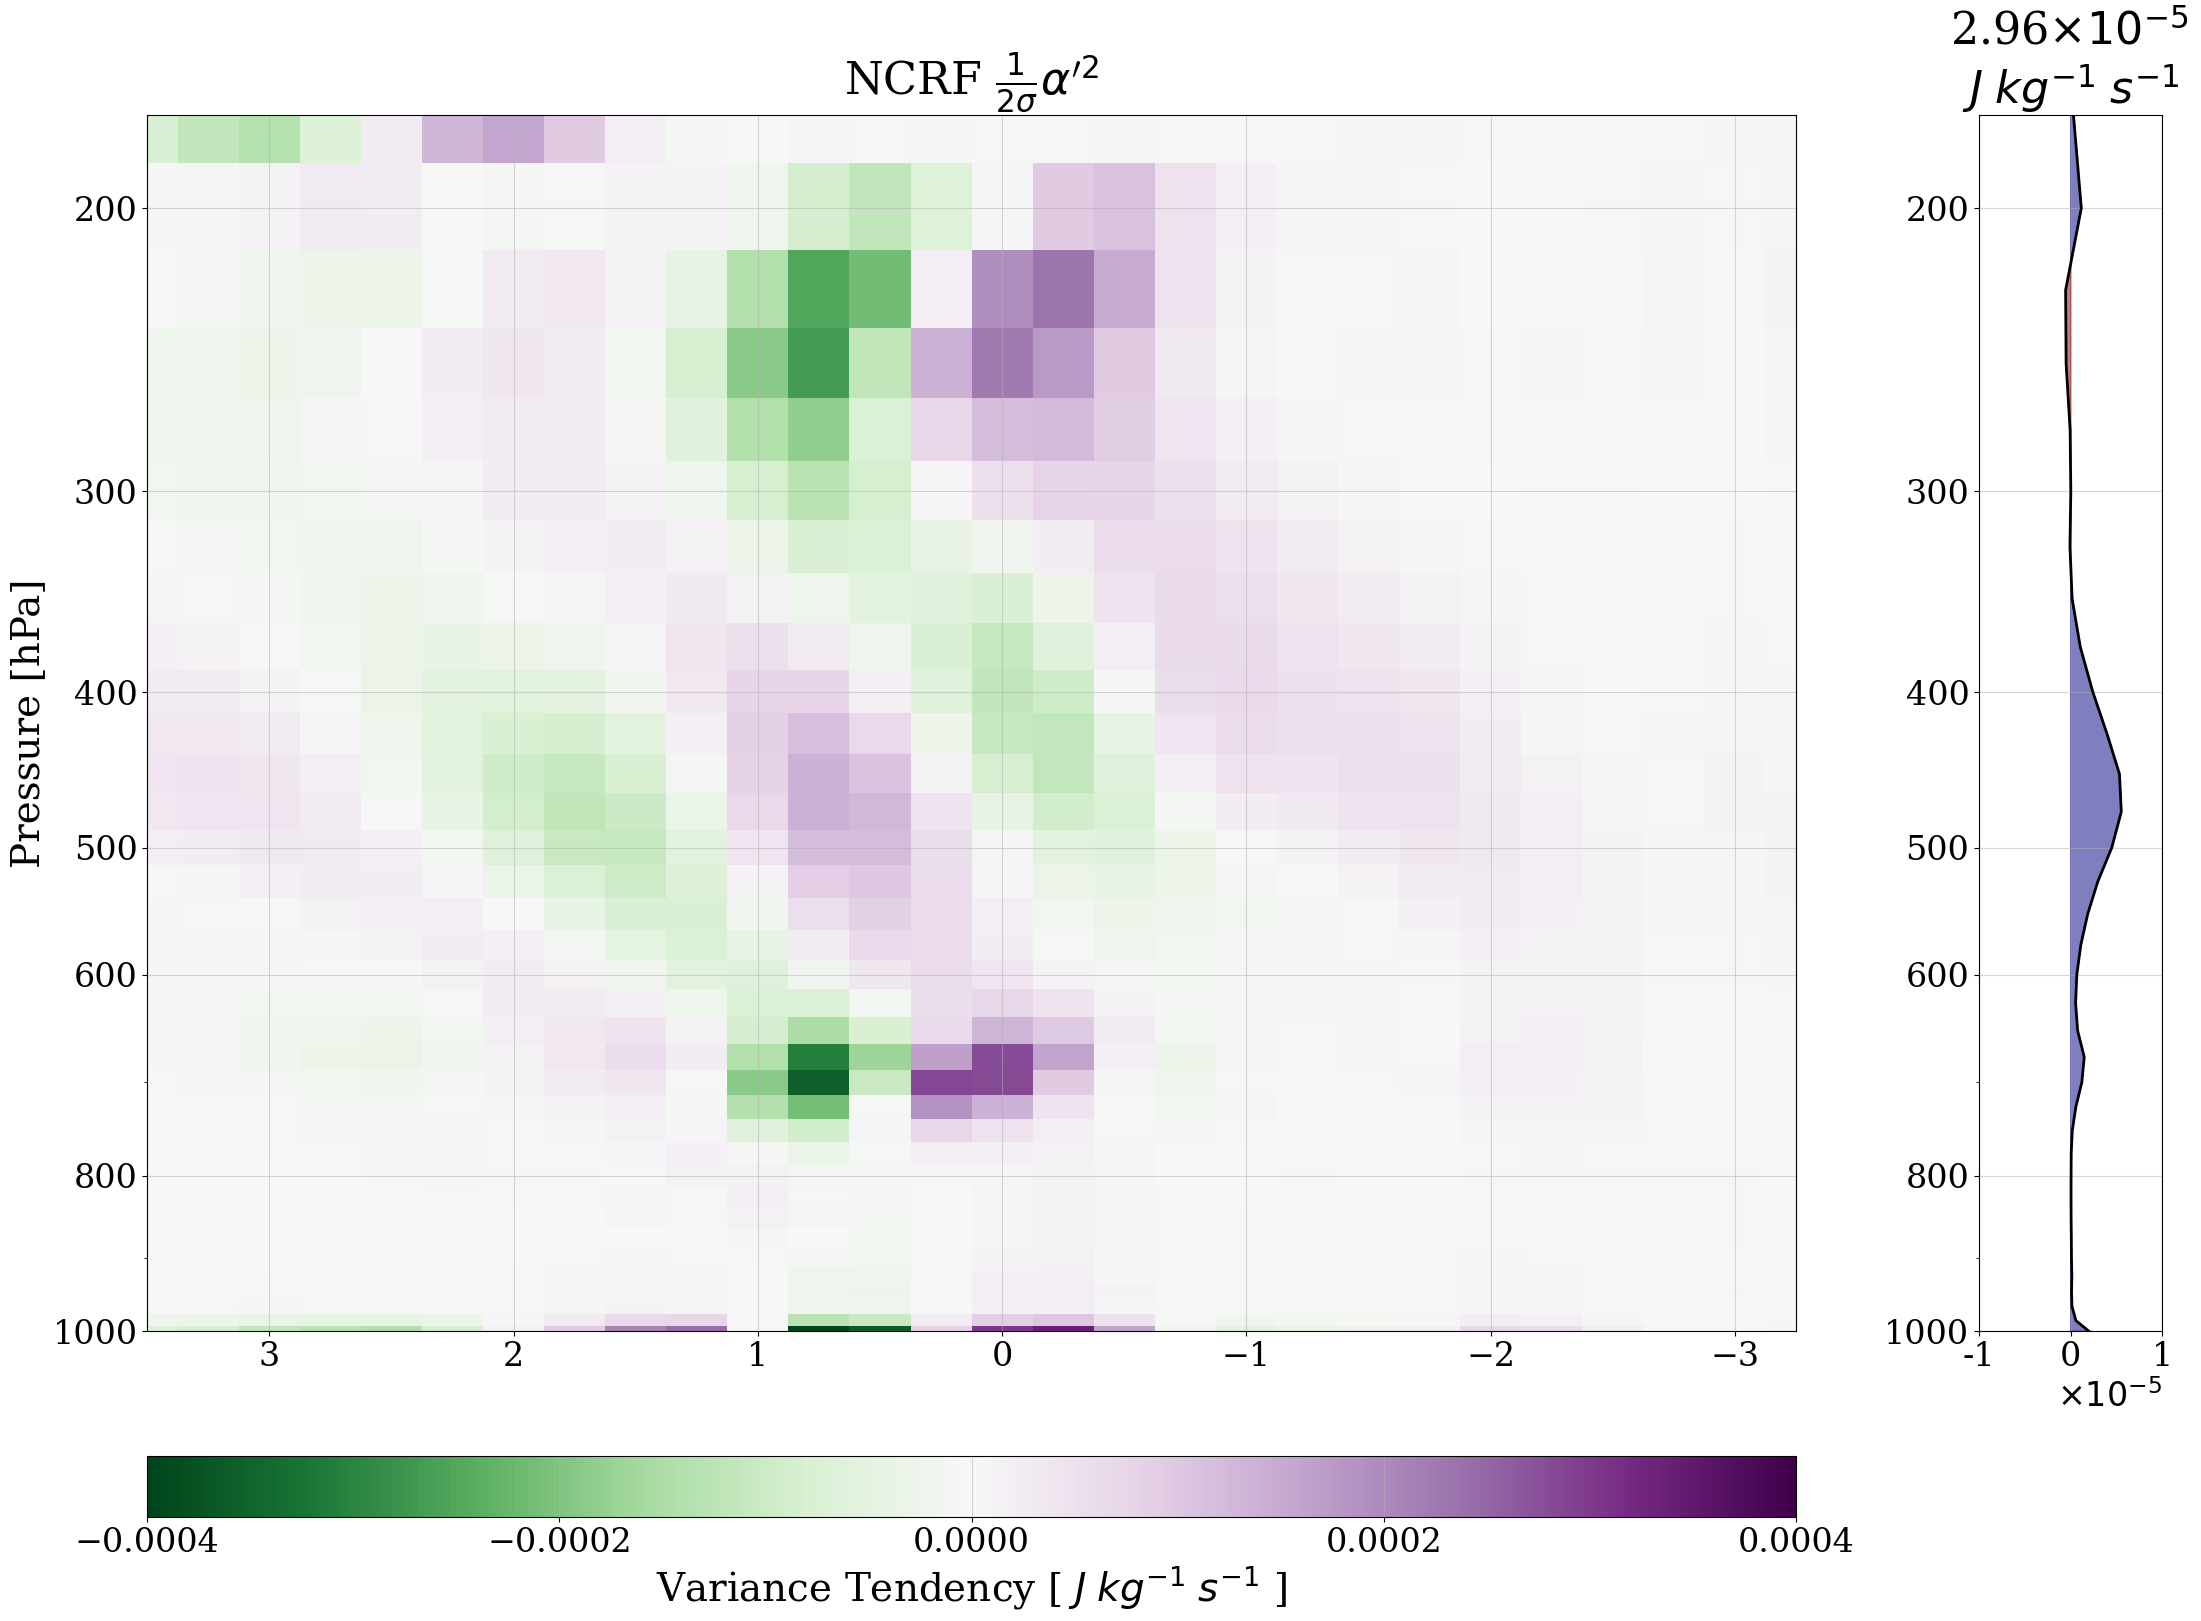

(36,)


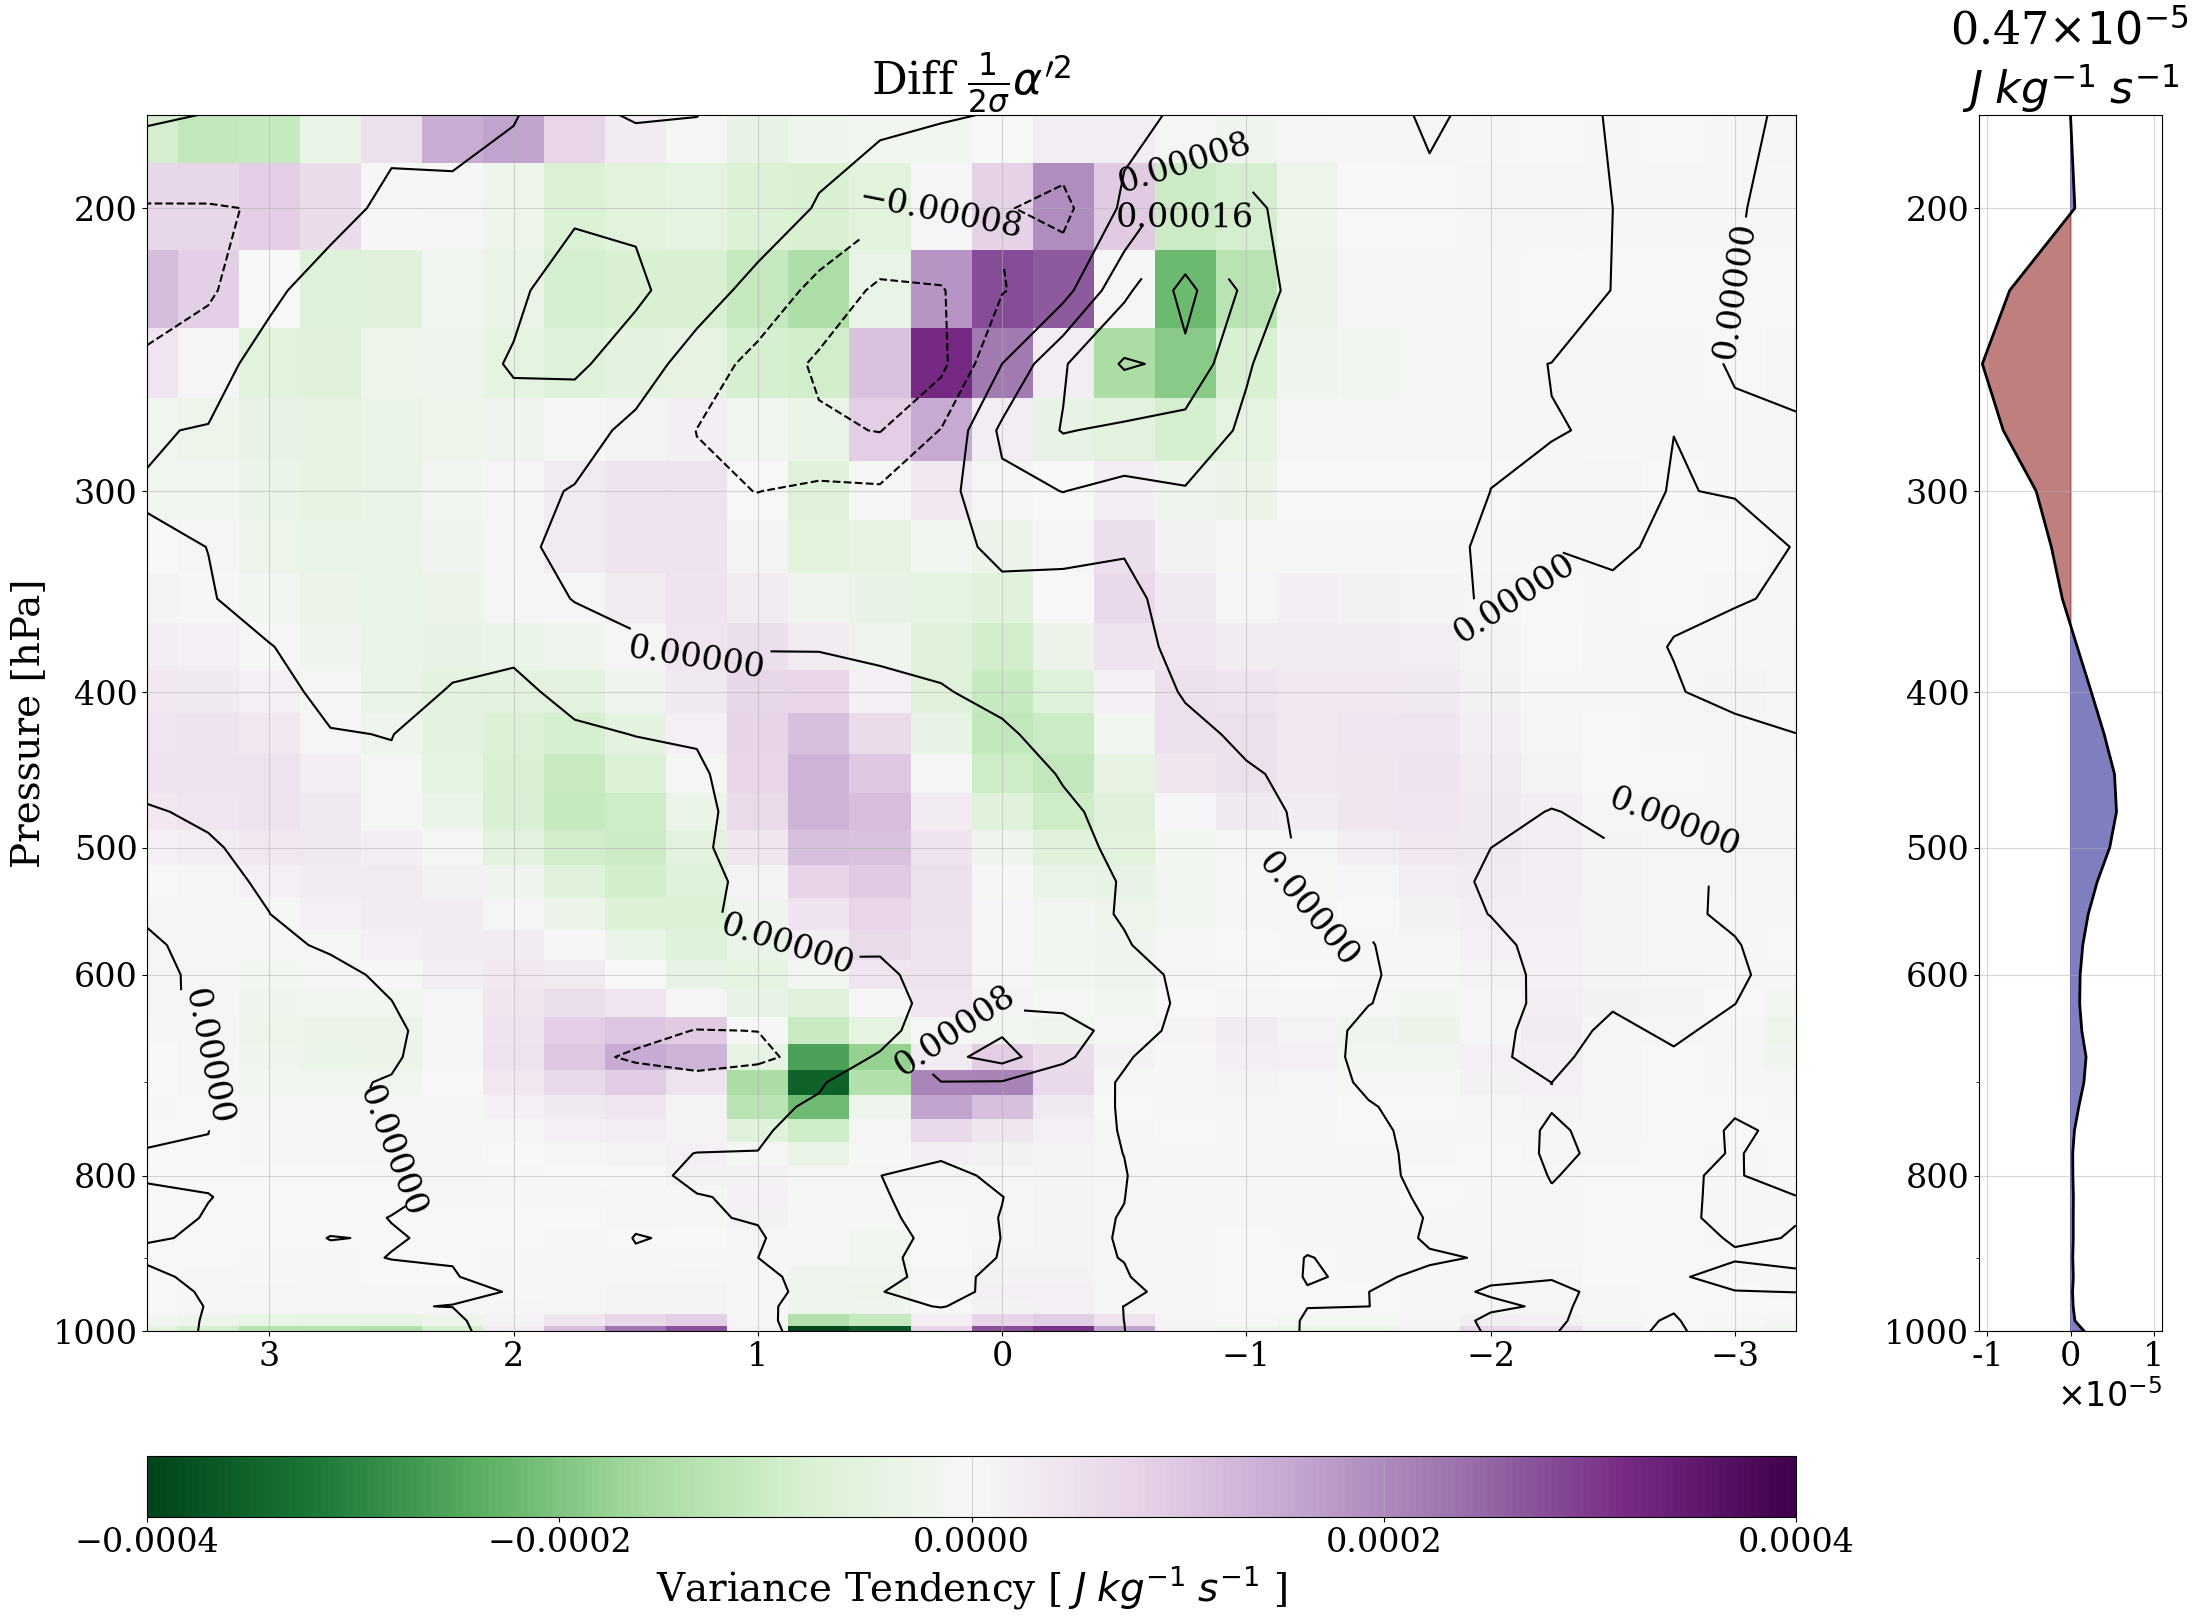

In [22]:
fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    var_tend["CNTL"][:z_lim],
    cmap="PRGn_r", norm=TwoSlopeNorm(0.0, vmin=-0.0004, vmax=0.0004),
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"CNTL $\frac{1}{2\sigma}\alpha^{\prime 2}$")

tend_sum = vert_int(dims["lev"][:z_lim], var_tend['CNTL'].sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(var_tend["CNTL"].mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(-1e-5, 1e-5, 3), ["-1", "0", "1"])
ax2.set_xlim(-1e-5, 1e-5)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-5}$", fontsize=24, loc="right")
ax2.set_title(f"{tend_sum*1e5:.2f}"+r"$\times 10^{-5}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")
ax2.fill_betweenx(
    z, 0, var_tend["CNTL"].mean(axis=1)[:z_lim],
    where=var_tend["CNTL"].mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, var_tend["CNTL"].mean(axis=1)[:z_lim], 0,
    where=var_tend["CNTL"].mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Variance Tendency [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=[-0.0004, -0.0002, 0, 0.0002, 0.0004]
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Tendency/CNTL.png", dpi=300)
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    var_tend["NCRF"][:z_lim],
    cmap="PRGn_r", norm=TwoSlopeNorm(0.0, vmin=-0.0004, vmax=0.0004),
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"NCRF $\frac{1}{2\sigma}\alpha^{\prime 2}$")

tend_sum = vert_int(dims["lev"][:z_lim], var_tend['NCRF'].sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(var_tend["NCRF"].mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(-1e-5, 1e-5, 3), ["-1", "0", "1"])
ax2.set_xlim(-1e-5, 1e-5)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-5}$", fontsize=24, loc="right")
ax2.set_title(f"{tend_sum*1e5:.2f}"+r"$\times 10^{-5}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")
ax2.fill_betweenx(
    z, 0, var_tend["NCRF"].mean(axis=1)[:z_lim],
    where=var_tend["NCRF"].mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, var_tend["NCRF"].mean(axis=1)[:z_lim], 0,
    where=var_tend["NCRF"].mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Variance Tendency [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=[-0.0004, -0.0002, 0, 0.0002, 0.0004]
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Tendency/NCRF.png", dpi=300)
plt.show()
plt.close(fig)



fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    tend_diff[:z_lim],
    cmap="PRGn_r", norm=TwoSlopeNorm(0.0, vmin=-0.0004, vmax=0.0004),
)
ct = ax1.contour(
    xx, zz,
    var_tend["CNTL"][:z_lim], colors="k"
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"Diff $\frac{1}{2\sigma}\alpha^{\prime 2}$")
plt.clabel(ct, inline=True)

tend_sum = vert_int(dims["lev"][:z_lim], tend_diff.sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(tend_diff.mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(-1e-5, 1e-5, 3), ["-1", "0", "1"])
ax2.set_xlim(-1.1e-5, 1.1e-5)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-5}$", fontsize=24, loc="right")
ax2.set_title(f"{tend_sum*1e5:.2f}"+r"$\times 10^{-5}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")
ax2.fill_betweenx(
    z, 0, tend_diff.mean(axis=1)[:z_lim],
    where=tend_diff.mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, tend_diff.mean(axis=1)[:z_lim], 0,
    where=tend_diff.mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Variance Tendency [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=[-0.0004, -0.0002, 0, 0.0002, 0.0004]
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Tendency/diff.png", dpi=300)
plt.show()
plt.close(fig)

#### Generation + Conversion

(36,)


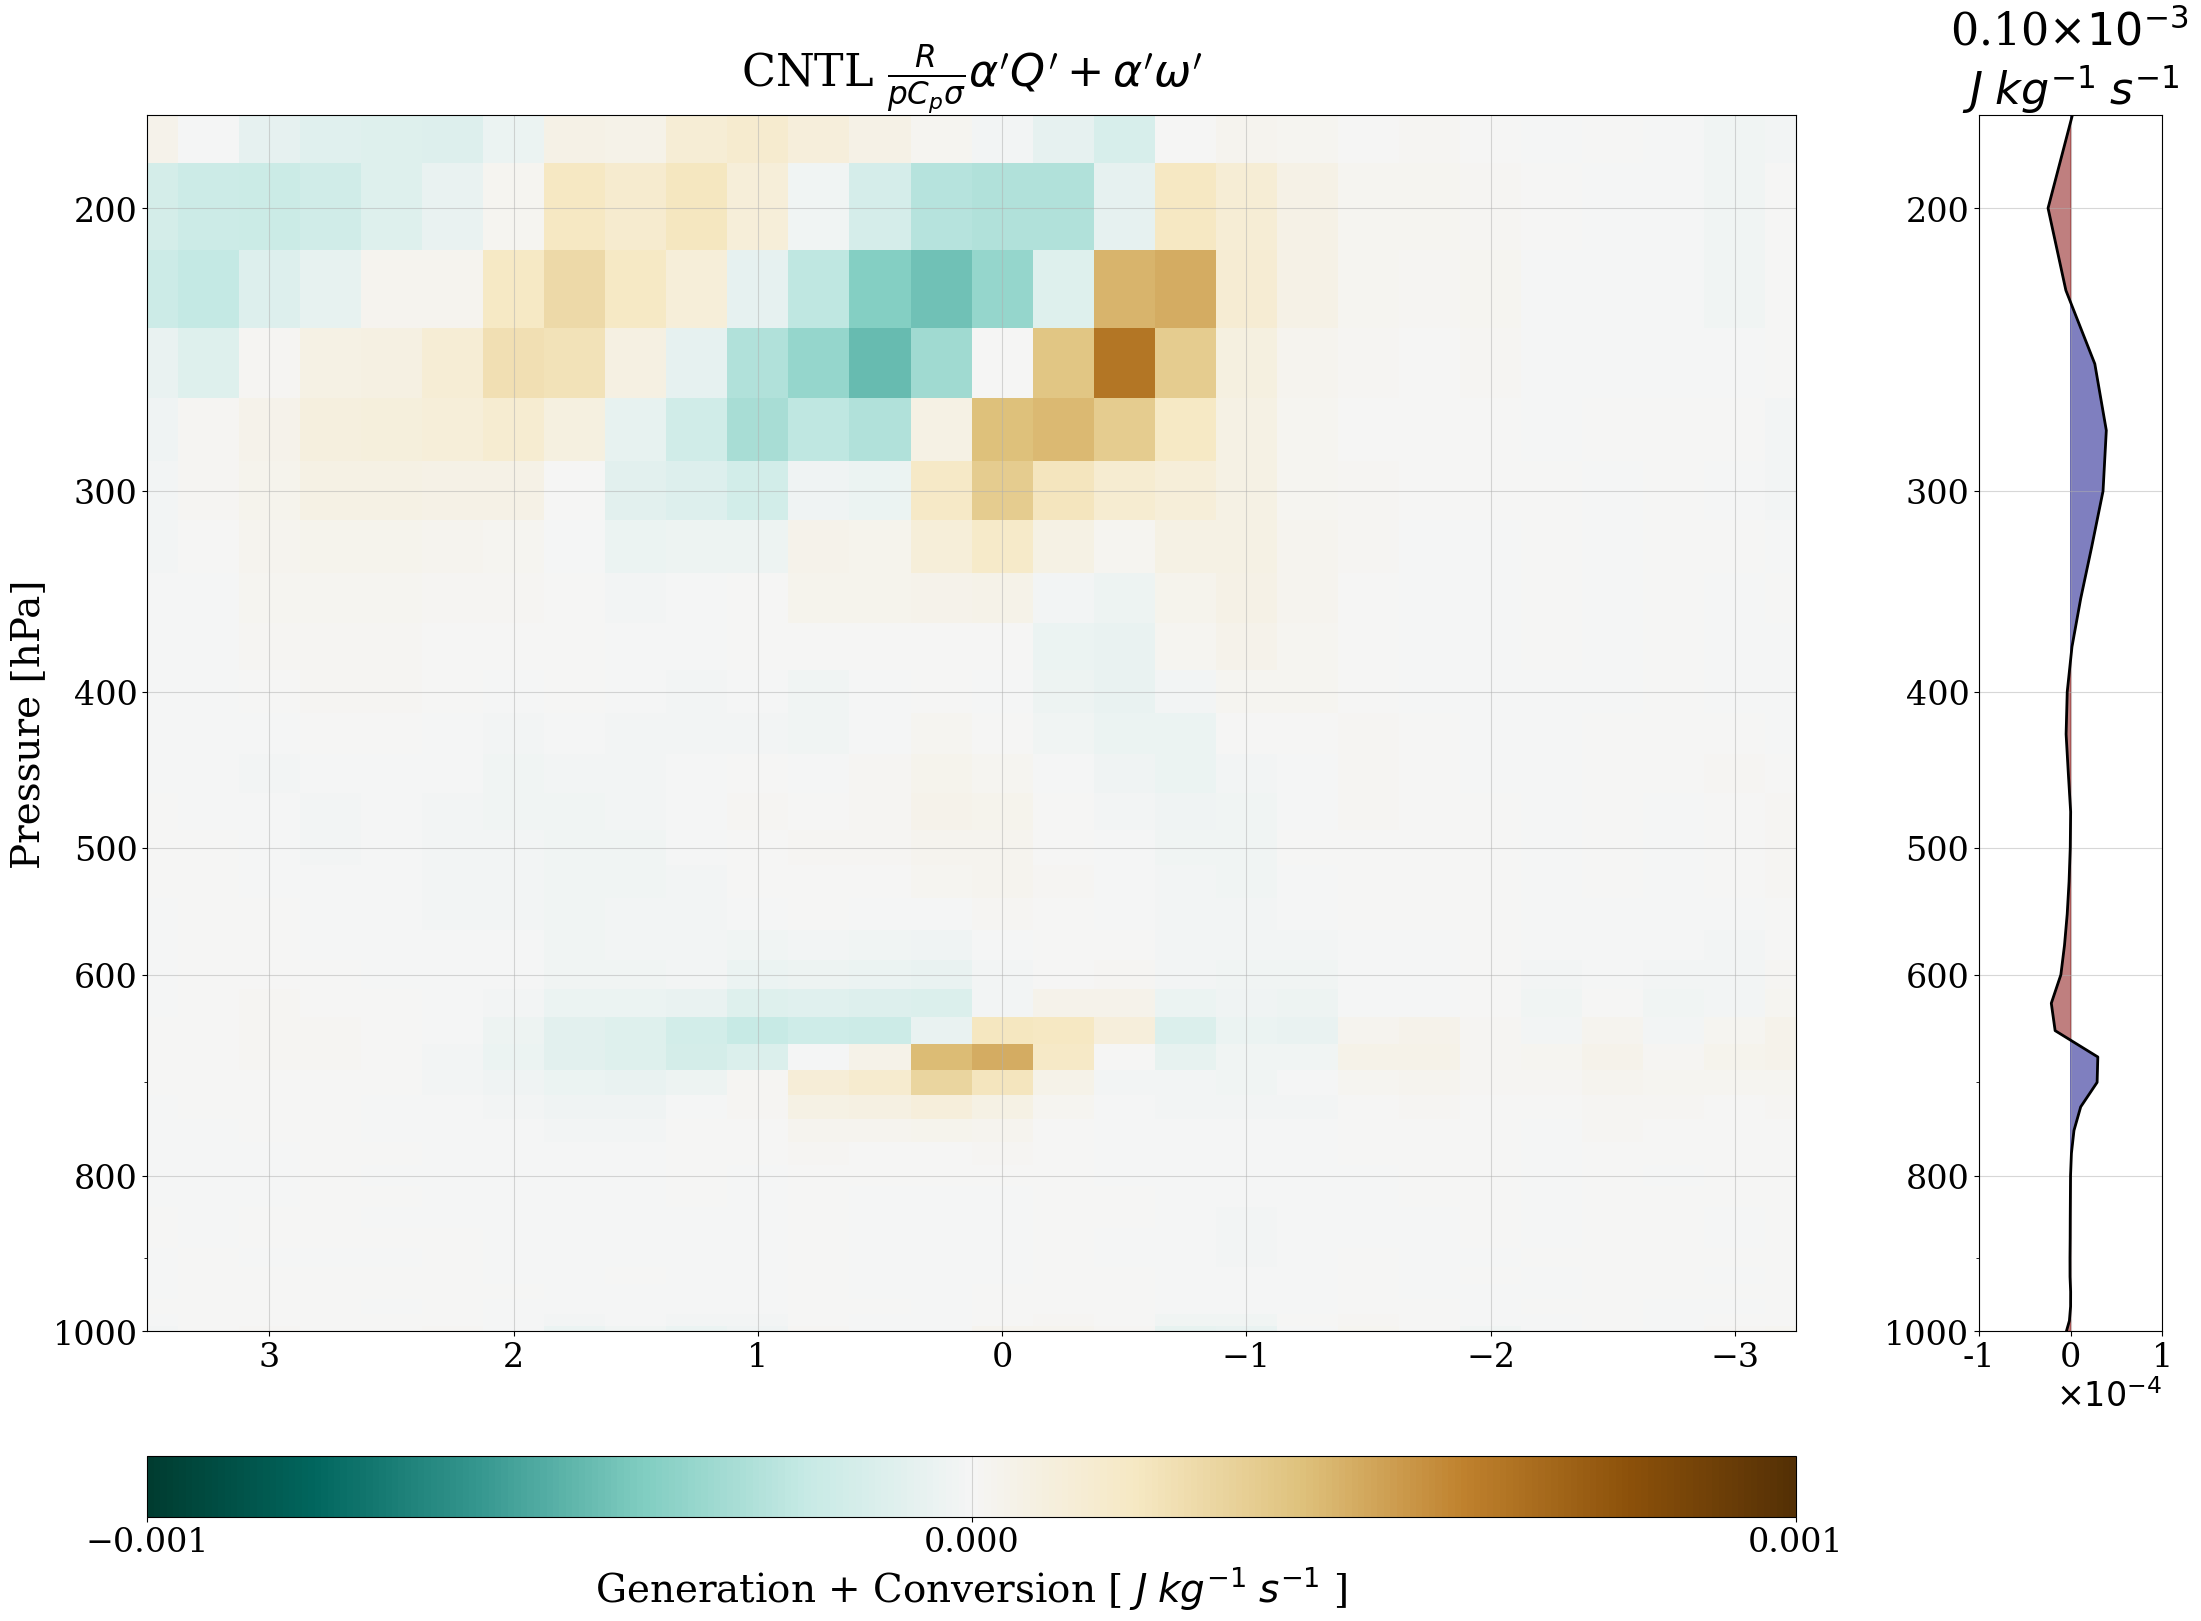

(36,)


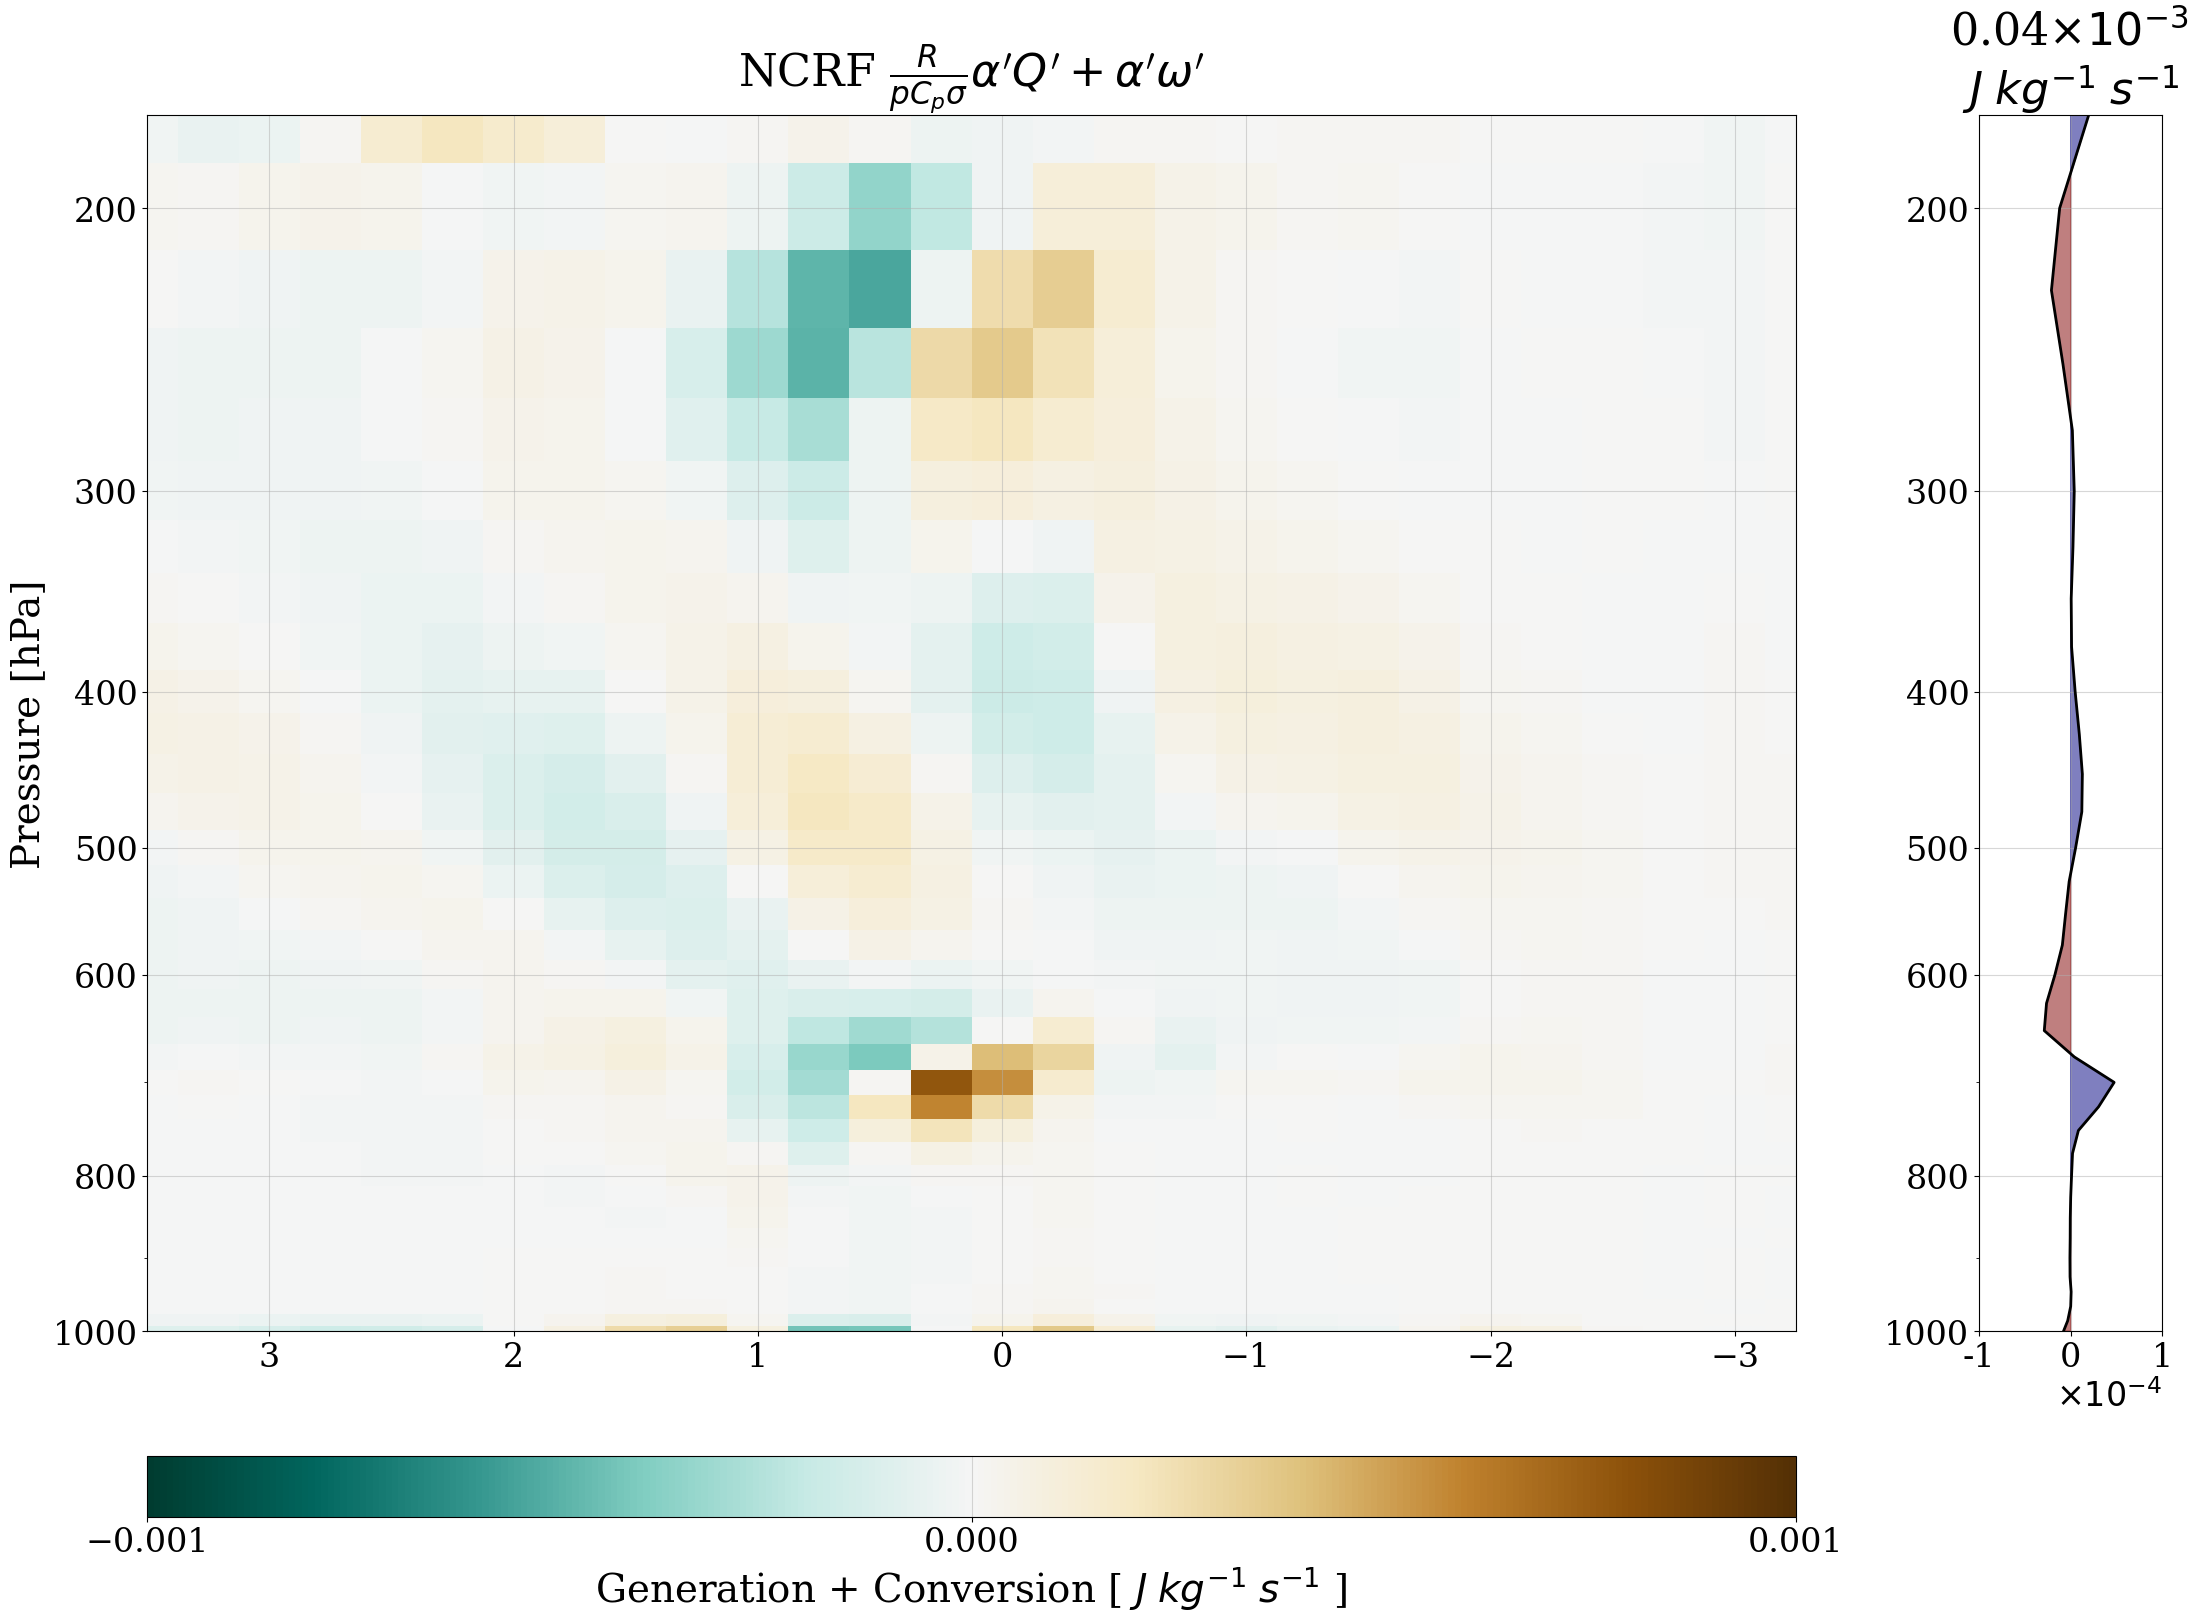

(36,)


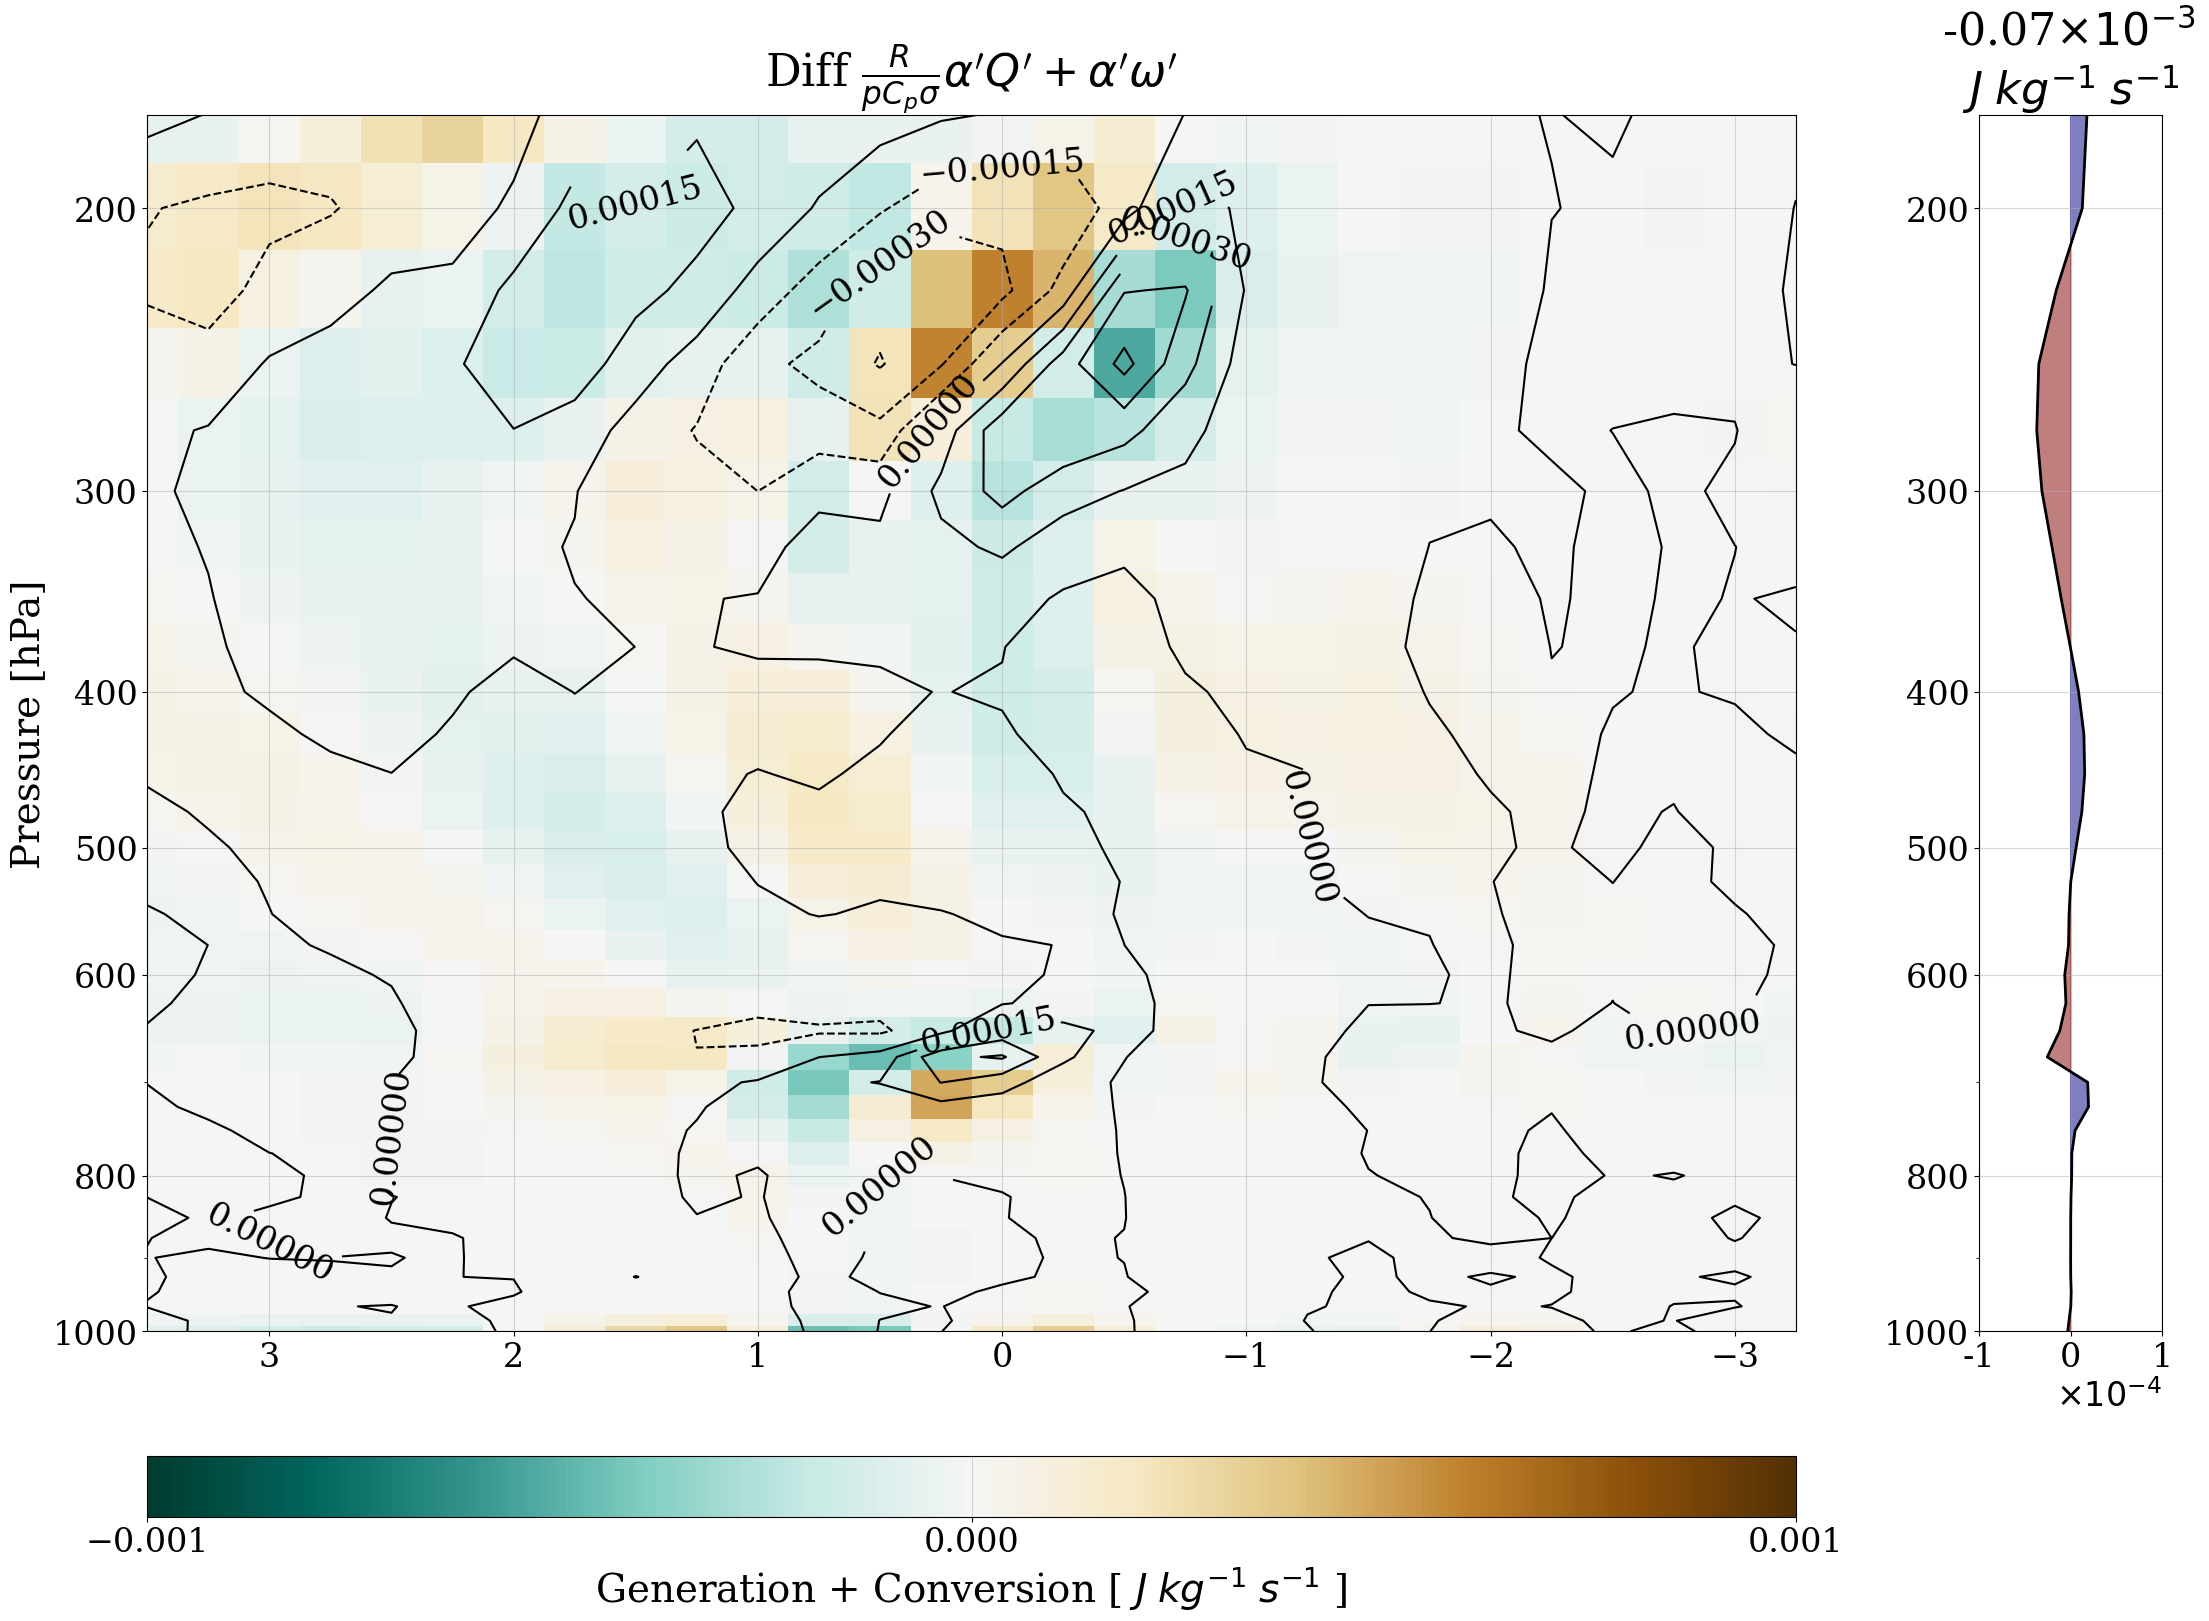

In [24]:
fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    (gen["CNTL"] + conv["CNTL"])[:z_lim],
    cmap="BrBG_r", norm=TwoSlopeNorm(0.0, vmin=-0.001, vmax=0.001),
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"CNTL $\frac{R}{p C_p \sigma} \alpha^\prime Q^\prime + \alpha^\prime \omega^\prime$")

conv_sum = vert_int(dims["lev"][:z_lim], (gen['CNTL'] + conv['CNTL']).sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot((gen["CNTL"] + conv["CNTL"]).mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(-1e-4, 1e-4, 3), ["-1", "0", "1"])
ax2.set_xlim(-1e-4, 1e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{conv_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")
ax2.fill_betweenx(
    z, 0, (gen["CNTL"] + conv["CNTL"]).mean(axis=1)[:z_lim],
    where=(gen["CNTL"] + conv["CNTL"]).mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, (gen["CNTL"] + conv["CNTL"]).mean(axis=1)[:z_lim], 0,
    where=(gen["CNTL"] + conv["CNTL"]).mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Generation + Conversion [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=[-0.001, 0, 0.001]
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Gen+Conv/CNTL.png", dpi=300)
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    (gen["NCRF"] + conv["NCRF"])[:z_lim],
    cmap="BrBG_r", norm=TwoSlopeNorm(0.0, vmin=-0.001, vmax=0.001),
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"NCRF $\frac{R}{p C_p \sigma} \alpha^\prime Q^\prime + \alpha^\prime \omega^\prime$")

conv_sum = vert_int(dims["lev"][:z_lim], (gen['NCRF'] + conv['NCRF']).sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot((gen["NCRF"] + conv["NCRF"]).mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(-1e-4, 1e-4, 3), ["-1", "0", "1"])
ax2.set_xlim(-1e-4, 1e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{conv_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")
ax2.fill_betweenx(
    z, 0, (gen["NCRF"] + conv["NCRF"]).mean(axis=1)[:z_lim],
    where=(gen["NCRF"] + conv["NCRF"]).mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, (gen["NCRF"] + conv["NCRF"]).mean(axis=1)[:z_lim], 0,
    where=(gen["NCRF"] + conv["NCRF"]).mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Generation + Conversion [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=np.linspace(-0.001, 0.001, 3)
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Gen+Conv/NCRF.png", dpi=300)
plt.show()
plt.close(fig)



fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    (gen_diff + conv_diff)[:z_lim],
    cmap="BrBG_r", norm=TwoSlopeNorm(0.0, vmin=-0.001, vmax=0.001),
)
ct = ax1.contour(
    xx, zz,
    (gen["CNTL"] + conv["CNTL"])[:z_lim],
    colors="k", 
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"Diff $\frac{R}{p C_p \sigma} \alpha^\prime Q^\prime + \alpha^\prime \omega^\prime$")
plt.clabel(ct, inline=True)

conv_sum = vert_int(dims["lev"][:z_lim], (gen_diff + conv_diff).sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot((gen_diff + conv_diff).mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.set_xticks(np.linspace(-1e-4, 1e-4, 3), ["-1", "0", "1"])
ax2.set_xlim(-1e-4, 1e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{conv_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")
ax2.fill_betweenx(
    z, 0, (gen_diff + conv_diff).mean(axis=1)[:z_lim],
    where=(gen_diff + conv_diff).mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, (gen_diff + conv_diff).mean(axis=1)[:z_lim], 0,
    where=(gen_diff + conv_diff).mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Generation + Conversion [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=np.linspace(-0.001, 0.001, 3)
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Gen+Conv/diff.png", dpi=300)
plt.show()
plt.close(fig)